In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset, Dataset,random_split

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

from torch.utils.data import Dataset

import pandas as pd
import shutil

import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import models
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score, recall_score

import os
import cv2
from PIL import Image, ImageEnhance, ImageFilter
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
!curl -L -o Font_recognition.zip https://github.com/NextGen-AI-Camp/curriculum/releases/download/Workshop/Font_recognition.zip
!unzip -o  /content/Font_recognition.zip

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: images/9ac8a008-12f8-4eb9-a4ef-c2f2d78ccc4e.jpg  
  inflating: images/9adb4195-2a08-4a72-800b-0ceccdd92c56.jpg  
  inflating: images/9ae5ebcc-b744-458c-8ebc-c0bb00ded94a.jpg  
  inflating: images/9ae7c34f-e754-430a-af69-a269c82e0185.jpg  
  inflating: images/9aefd856-6027-4524-bf6b-585aaffc4f64.jpg  
  inflating: images/9af13c53-91e7-4dda-b880-f3d3fa0c3cc2.jpg  
  inflating: images/9afb1f5b-b579-4ea3-b6a8-11afe99c2ac0.jpg  
  inflating: images/9aff54d3-8d05-40e2-9961-0e497fdee70d.jpg  
  inflating: images/9b001318-5721-489f-956d-127dc01c4aba.jpg  
  inflating: images/9b116749-3595-40d6-b592-e78a8d534295.jpg  
  inflating: images/9b12ef52-33f7-431d-83a2-2b7ee3d55e76.jpg  
  inflating: images/9b157027-bb83-40c1-b61b-8bcce87a8c9b.jpg  
  inflating: images/9b1b93f3-4486-4f81-bc9c-22dc7e618e6f.jpg  
  inflating: images/9b1e81ed-04f0-4180-8ef3-051c94f64739.jpg  
  inflating: images/9b1f0e9e-db1c-48dd-835f-c61b1951a4b2.jpg 

In [ ]:
def process_csv(csv_path, images_folder, output_base_folder, has_labels=False):
    df = pd.read_csv(csv_path)

    if not os.path.exists(output_base_folder):
        os.makedirs(output_base_folder)

    for index, row in df.iterrows():
        image_path = row['image_path']
        if has_labels:
            font = row.get('font', 'unknown_font')
            font_size = row.get('font_size', 'unknown_size')
            color = row.get('color', 'unknown_color').replace("#", "")

            class_folder = os.path.join(
                output_base_folder,
                color,
                font,
                f"size_{font_size}"
            )
            if not os.path.exists(class_folder):
                os.makedirs(class_folder)
        else:
            class_folder = output_base_folder

        source = os.path.join(images_folder, os.path.basename(image_path))
        destination = os.path.join(class_folder, os.path.basename(image_path))

        if os.path.exists(source):
            shutil.copy2(source, destination)
        else:
            print(f"File {os.path.basename(image_path)} does not exist in {images_folder}")

train_csv_path = '/content/train.csv'
test_csv_path = '/content/test.csv'
images_folder = '/content/images'

train_output_base_folder = '/content/train_pic'
test_output_base_folder = '/content/test_pic'

process_csv(train_csv_path, images_folder, train_output_base_folder, has_labels=True)
process_csv(test_csv_path, images_folder, test_output_base_folder, has_labels=False)

In [ ]:
class MultiAlphabetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        self.color_mapping = {'FF6666': 0, '0000FF': 1, 'A020F0': 2, 'DF3030': 3, '26E953': 4}
        self.font_mapping = {'Athiti-Regular': 0, 'Sarabun-Regular': 1, 'NotoSerifThai-Regular': 2,
                             'Kodchasan-Regular': 3, 'Prompt-Regular': 4, 'KhaosuayThin': 5, 'FkBeautyRegular': 6}
        self.font_size_mapping = {18: 0, 20: 1, 22: 2, 24: 3, 26: 4, 28: 5}

        for color_dir in os.scandir(root_dir):
            if color_dir.is_dir():
                color = color_dir.name
                for font_dir in os.scandir(color_dir.path):
                    if font_dir.is_dir():
                        font = font_dir.name
                        for size_dir in os.scandir(font_dir.path):
                            if size_dir.is_dir() and size_dir.name.startswith("size_"):
                                font_size = int(size_dir.name.split('_')[1])
                                for file in os.scandir(size_dir.path):
                                    if file.is_file():
                                        self.samples.append((file.path, font, font_size, color))

        print(f"Total samples found: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, font, font_size, color = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        font_encoded = torch.tensor(self.font_mapping.get(font), dtype=torch.long)
        font_size_encoded = torch.tensor(self.font_size_mapping.get(font_size), dtype=torch.long)
        color_encoded = torch.tensor(self.color_mapping.get(color), dtype=torch.long)

        return image, color_encoded, font_encoded, font_size_encoded

In [ ]:
class ReverseIntensity:
  def __init__(self, threshold=150):
    self.threshold = threshold

  def __call__(self, image):

    if isinstance(image, Image.Image):
      image_np = np.array(image)
    elif isinstance(image, np.ndarray):
      image_np = image
    else:
      raise TypeError("Unsupported type. Expected PIL Image or numpy array.")

    if np.mean(image_np) > self.threshold:
      reversed_image = 255 - image_np
      return Image. fromarray(reversed_image)
    else:
      return image

In [ ]:
class Sharpen(object):
    def __call__(self, img):
        enhancer = ImageEnhance.Sharpness(img)
        return enhancer.enhance(5.0)

class BilateralFilter(object):
    def __init__(self, d=9, sigmaColor=90, sigmaSpace=90):
        self.d = d
        self.sigmaColor = sigmaColor
        self.sigmaSpace = sigmaSpace

    def __call__(self, img):
        img_np = np.array(img)
        filtered_img_np = cv2.bilateralFilter(img_np, self.d, self.sigmaColor, self.sigmaSpace)
        filtered_img = Image.fromarray(filtered_img_np)
        return filtered_img

class RemovedBackNoiseAndWhiteground:
        def __init__(self, threshold=(200, 200, 200)):
            self.threshold = threshold

        def __call__(self, img):

            img_np = np.array(img)

            mask = (img_np[..., 0] >= self.threshold[0]) & \
                (img_np[..., 1] >= self.threshold[1]) & \
                (img_np[..., 2] >= self.threshold[2])

            img_np[mask] = [255, 255, 255]

            return Image.fromarray(img_np)

transform = transforms.Compose([
              RemovedBackNoiseAndWhiteground(),
              BilateralFilter(d=9, sigmaColor=87.5, sigmaSpace=87.5),
              Sharpen(),
              transforms.CenterCrop((32, 480)),
              transforms.ToTensor()
              ])


root_dir = '/content/train_pic'
dataset = MultiAlphabetDataset(root_dir=root_dir, transform=transform)

reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

images, colors, fonts, font_sizes = next(iter(dataloader))

color_names = [reverse_color_mapping[int(color)] for color in colors]
font_names = [reverse_font_mapping[int(font)] for font in fonts]
font_size_names = [reverse_font_size_mapping[int(font_size)] for font_size in font_sizes]

print(f"Batch Images Shape: {images.shape}")
print(f"Batch Colors: {color_names}")
print(f"Batch Fonts: {font_names}")
print(f"Batch Font Sizes: {font_size_names}")

Total samples found: 10080
Batch Images Shape: torch.Size([4, 3, 32, 480])
Batch Colors: ['A020F0', 'A020F0', '26E953', 'FF6666']
Batch Fonts: ['FkBeautyRegular', 'Athiti-Regular', 'FkBeautyRegular', 'Athiti-Regular']
Batch Font Sizes: [24, 20, 24, 22]


In [ ]:
def load_data(reverse=False, normalize=False, batch_size=32):
    root_dir = '/content/train_pic'

    train_transform = transforms.Compose([
          RemovedBackNoiseAndWhiteground(),
          BilateralFilter(d=9, sigmaColor=87.5, sigmaSpace=87.5),
          Sharpen(),
          transforms.CenterCrop((32, 480)),
          transforms.ToTensor()
          ])

    dataset = MultiAlphabetDataset(root_dir=root_dir, transform=train_transform)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [ ]:
train_loader, test_loader = load_data(reverse=False, normalize=False, batch_size=32)

Total samples found: 10080


In [ ]:
def get_dataset_stats(loader):
    font_count = {}
    font_size_count = {}
    color_count = {}
    total_samples = 0

    reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
    reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
    reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

    for batch in loader:
        images, colors, fonts, font_sizes = batch

        color_names = [reverse_color_mapping[int(color)] for color in colors]
        font_names = [reverse_font_mapping[int(font)] for font in fonts]
        font_size_names = [reverse_font_size_mapping[int(font_size)] for font_size in font_sizes]

        for color in color_names:
            if color not in color_count:
                color_count[color] = 0
            color_count[color] += 1

        for font in font_names:
            if font not in font_count:
                font_count[font] = 0
            font_count[font] += 1

        for font_size in font_size_names:
            if font_size not in font_size_count:
                font_size_count[font_size] = 0
            font_size_count[font_size] += 1

        total_samples += len(images)

    return font_count, font_size_count, color_count, total_samples

In [ ]:
train_font_count, train_font_size_count, train_color_count, train_total_samples = get_dataset_stats(train_loader)
test_font_count, test_font_size_count, test_color_count, test_total_samples = get_dataset_stats(test_loader)

print("📃Train Dataset:")
for font, count in train_font_count.items():
    print(f"\tNumber of images with font {font}: {count}")
for font_size, count in train_font_size_count.items():
    print(f"\tNumber of images with font size {font_size}: {count}")
for color, count in train_color_count.items():
    print(f"\tNumber of images with color {color}: {count}")
print(f"\tNumber of training samples: {train_total_samples}")

print("📃Test Dataset:")
for font, count in test_font_count.items():
    print(f"\tNumber of images with font {font}: {count}")
for font_size, count in test_font_size_count.items():
    print(f"\tNumber of images with font size {font_size}: {count}")
for color, count in test_color_count.items():
    print(f"\tNumber of images with color {color}: {count}")
print(f"\tNumber of testing samples: {test_total_samples}")

📃Train Dataset:
	Number of images with font Athiti-Regular: 1163
	Number of images with font Prompt-Regular: 1160
	Number of images with font FkBeautyRegular: 1160
	Number of images with font Kodchasan-Regular: 1159
	Number of images with font Sarabun-Regular: 1133
	Number of images with font NotoSerifThai-Regular: 1176
	Number of images with font KhaosuayThin: 1113
	Number of images with font size 28: 1301
	Number of images with font size 18: 1351
	Number of images with font size 22: 1349
	Number of images with font size 20: 1349
	Number of images with font size 24: 1346
	Number of images with font size 26: 1368
	Number of images with color DF3030: 1603
	Number of images with color 0000FF: 1608
	Number of images with color FF6666: 1627
	Number of images with color 26E953: 1598
	Number of images with color A020F0: 1628
	Number of training samples: 8064
📃Test Dataset:
	Number of images with font Prompt-Regular: 280
	Number of images with font KhaosuayThin: 327
	Number of images with fon

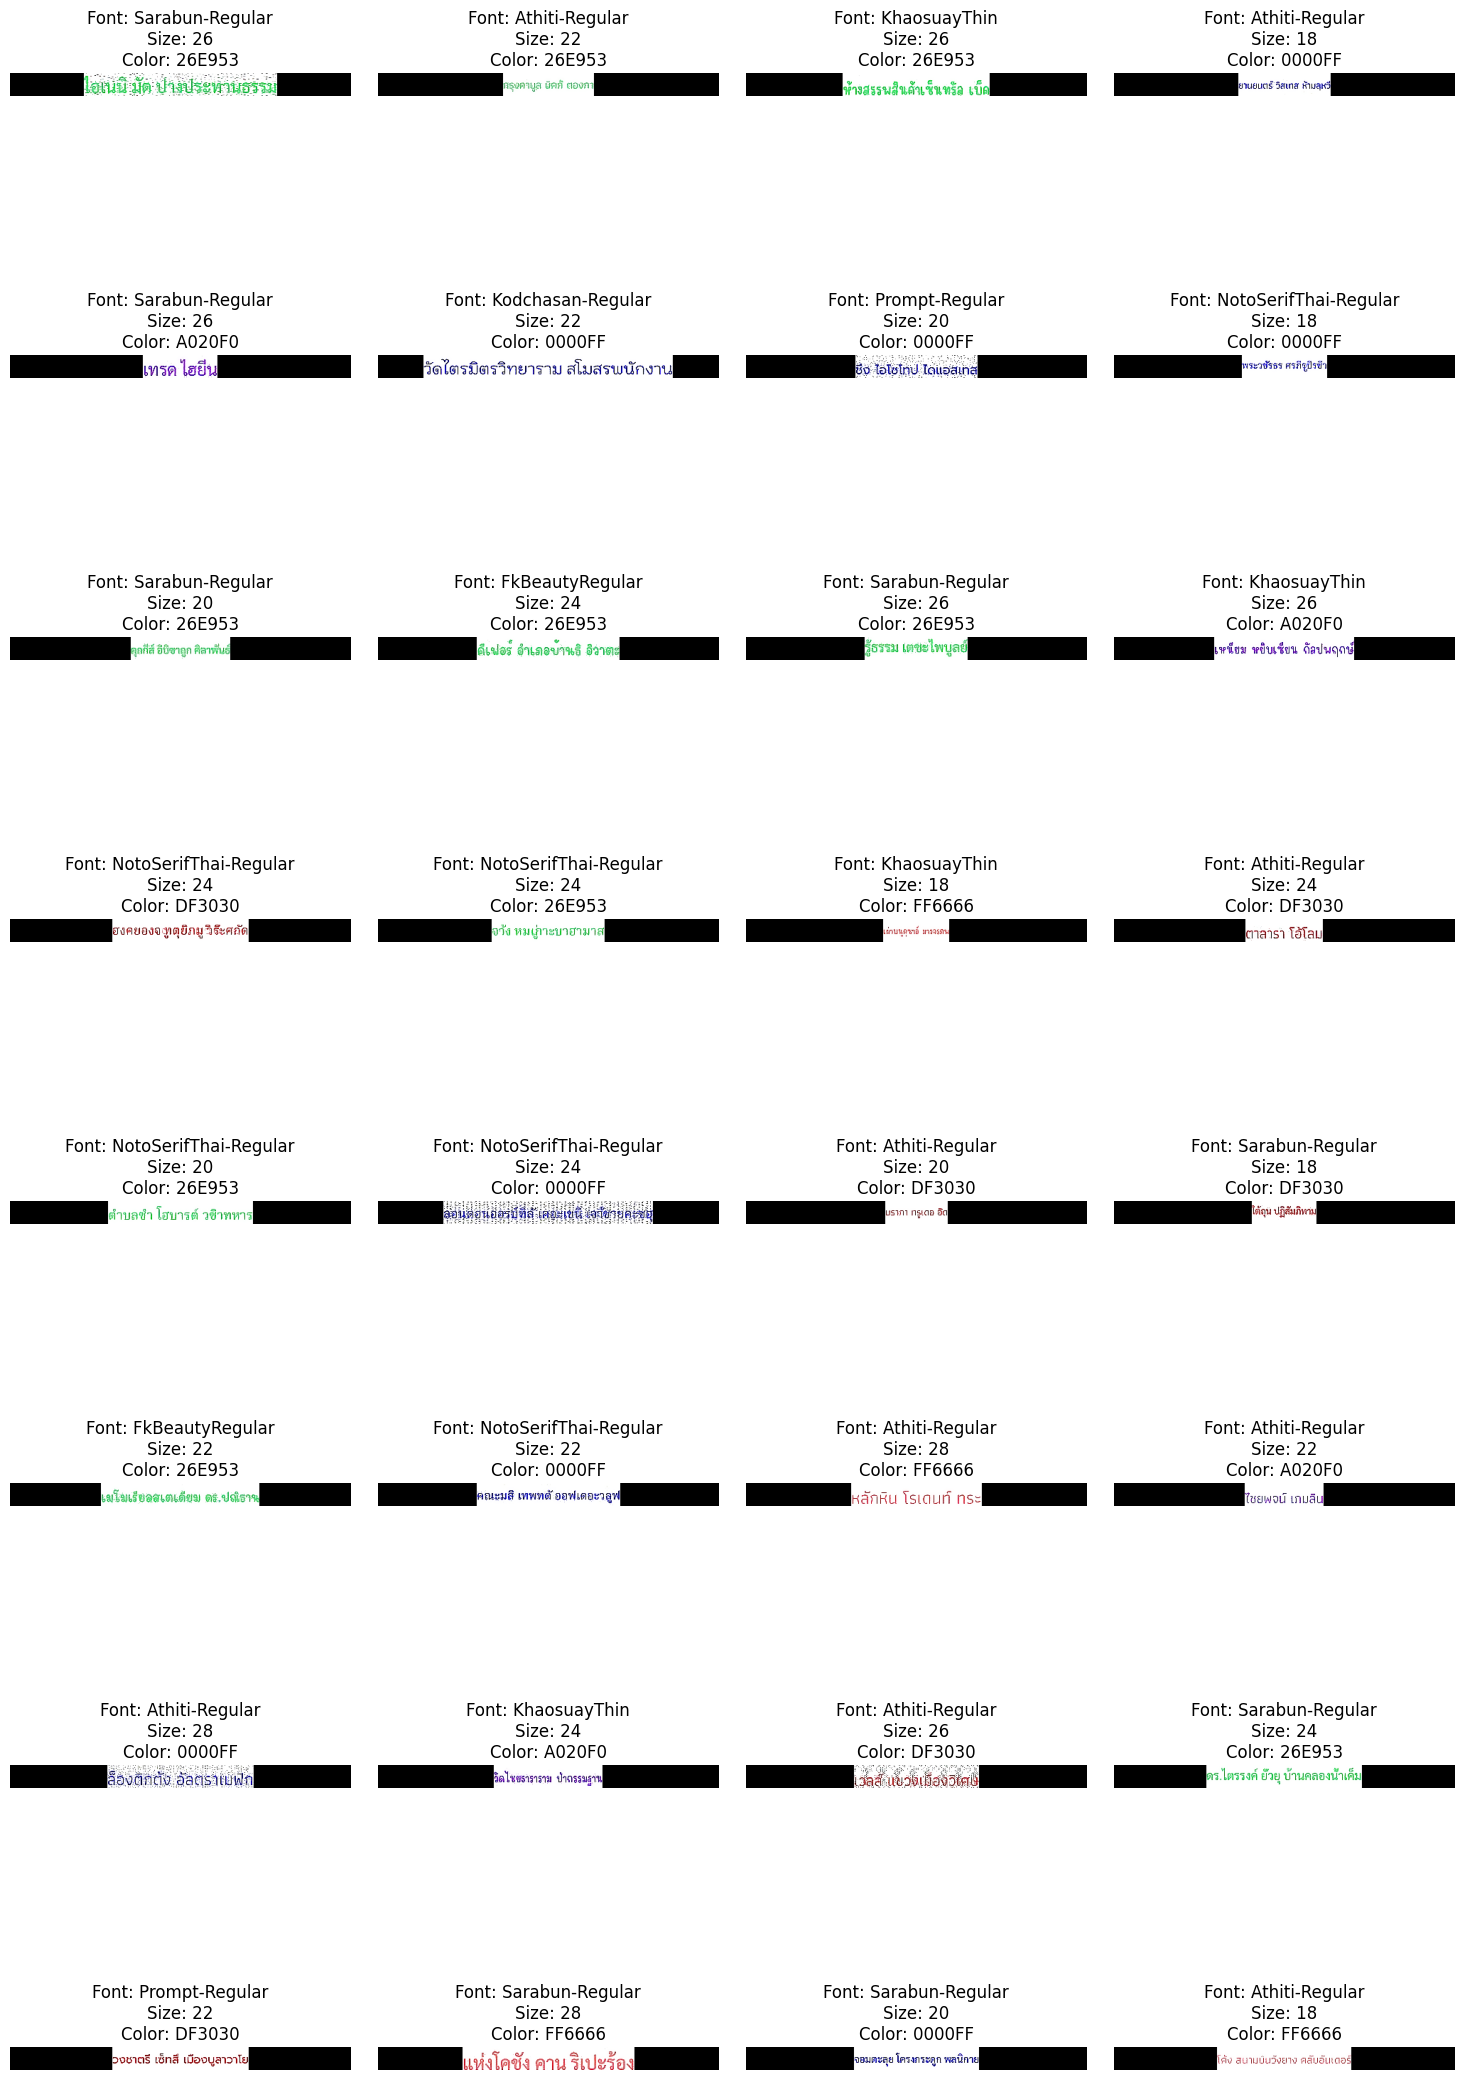

In [ ]:
batch_size = 32
images, colors, fonts, font_sizes = next(iter(train_loader))

reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

fig, axes = plt.subplots(8, 4, figsize=(15, 24))
axes = axes.flatten()

for idx, (img, color, font, font_size) in enumerate(zip(images[:batch_size], colors[:batch_size], fonts[:batch_size], font_sizes[:batch_size])):
    ax = axes[idx]

    img_np = img.permute(1, 2, 0).numpy()

    color_name = reverse_color_mapping[int(color)]
    font_name = reverse_font_mapping[int(font)]
    font_size_value = reverse_font_size_mapping[int(font_size)]

    ax.imshow(img_np)
    ax.set_title(f"Font: {font_name}\nSize: {font_size_value}\nColor: {color_name}")
    ax.axis('off')

for ax in axes[len(images[:batch_size]):]:
    ax.axis('off')

plt.tight_layout(pad=2.0)
plt.show()

In [ ]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 151MB/s]


In [ ]:
class CustomVGG16(nn.Module):
    def __init__(self,
                 num_colors=5,
                 num_fonts=7,
                 num_sizes=6,
                 h_dims_color=[256, 128, 128],
                 h_dims_font=[1024, 512, 512],
                 h_dims_size=[2024, 1024, 512],
                 input_size=(3, 32, 480)):
        super(CustomVGG16, self).__init__()

        self.vgg16 = models.vgg16(pretrained=True)
        self.vgg16.flatten = nn.Flatten()

        for param in self.vgg16.features.parameters():
            param.requires_grad = True

        for param in self.vgg16.classifier.parameters():
            param.requires_grad = True

        classifier = []
        in_features = self._get_input_size_fc(input_size)

        self.color_classifier = self._create_classifier(in_features, h_dims_color, num_colors)
        self.font_classifier = self._create_classifier(in_features, h_dims_font, num_fonts)
        self.size_classifier = self._create_classifier(in_features, h_dims_size, num_sizes)

    def _get_input_size_fc(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            x = self.vgg16.features(dummy_input)
            x = self.vgg16.avgpool(x)
            x = self.vgg16.flatten(x)
            return x.shape[-1]

    def _create_classifier(self, in_features, h_dims, num_classes):
        layers = []
        for hdim in h_dims:
            layers.append(nn.Linear(in_features, hdim))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=0.5))
            in_features = hdim
        layers.append(nn.Linear(in_features, num_classes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.vgg16.features(x)
        x = self.vgg16.avgpool(x)
        x = self.vgg16.flatten(x)

        color_output = self.color_classifier(x)
        font_output = self.font_classifier(x)
        size_output = self.size_classifier(x)

        return color_output, font_output, size_output

In [ ]:
num_colors = 5
num_fonts = 7
num_sizes = 6
model = CustomVGG16(num_colors, num_fonts, num_sizes, h_dims_color=[256, 128, 128], h_dims_font=[1024, 512, 512],h_dims_size=[2024, 1024, 512])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
best_score = 0.0

def calculate_fbeta_score(precision, recall, beta):
    beta_squared = beta ** 2
    return (1 + beta_squared) * (precision * recall) / ((beta_squared * precision) + recall + 1e-7)

def train(model,
          optimizer,
          train_loader,
          test_loader,
          epochs=10,
          beta=2,
          checkpoint_path=None,
          device='cpu'):
    global best_score
    model = model.to(device)
    print("🤖 Training on", device)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(epochs):
        model.train()

        cross_entropy_loss = nn.CrossEntropyLoss()

        train_bar = tqdm(train_loader,
                         desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]',
                         unit='batch')

        for batch_idx, (data, color_target, font_target, size_target) in enumerate(train_bar):
            data, color_target, font_target, size_target = data.to(device), color_target.to(device), font_target.to(device), size_target.to(device)

            optimizer.zero_grad()

            color_output, font_output, size_output = model(data)
            loss_color = cross_entropy_loss(color_output, color_target)
            loss_font = cross_entropy_loss(font_output, font_target)
            loss_size = cross_entropy_loss(size_output, size_target)

            loss = (loss_color*1.0 + loss_font*1.3 + loss_size*1.5)

            loss.backward()
            optimizer.step()

            train_bar.set_postfix(loss=loss.item())

        model.eval()
        scheduler.step()

        correct_color, correct_font, correct_size = 0, 0, 0
        test_loss_color, test_loss_font, test_loss_size = 0, 0, 0

        all_color_preds, all_color_targets = [], []
        all_font_preds, all_font_targets = [], []
        all_size_preds, all_size_targets = [], []

        with torch.no_grad():
            test_bar = tqdm(test_loader,
                            desc=f"🧪 Testing Epoch [{epoch+1}/{epochs}]",
                            unit='batch')

            for data, color_target, font_target, size_target in test_bar:
                data, color_target, font_target, size_target = data.to(device), color_target.to(device), font_target.to(device), size_target.to(device)

                color_output, font_output, size_output = model(data)

                test_loss_color += cross_entropy_loss(color_output, color_target).item()
                test_loss_font += cross_entropy_loss(font_output, font_target).item()
                test_loss_size += cross_entropy_loss(size_output, size_target).item()

                color_pred = color_output.argmax(dim=1, keepdim=True)
                font_pred = font_output.argmax(dim=1, keepdim=True)
                size_pred = size_output.argmax(dim=1, keepdim=True)

                correct_color += color_pred.eq(color_target.view_as(color_pred)).sum().item()
                correct_font += font_pred.eq(font_target.view_as(font_pred)).sum().item()
                correct_size += size_pred.eq(size_target.view_as(size_pred)).sum().item()

                all_color_preds.extend(color_pred.cpu().numpy())
                all_color_targets.extend(color_target.cpu().numpy())
                all_font_preds.extend(font_pred.cpu().numpy())
                all_font_targets.extend(font_target.cpu().numpy())
                all_size_preds.extend(size_pred.cpu().numpy())
                all_size_targets.extend(size_target.cpu().numpy())

            test_loss_color /= len(test_loader.dataset)
            test_loss_font /= len(test_loader.dataset)
            test_loss_size /= len(test_loader.dataset)

            accuracy_color = 100. * correct_color / len(test_loader.dataset)
            accuracy_font = 100. * correct_font / len(test_loader.dataset)
            accuracy_size = 100. * correct_size / len(test_loader.dataset)

            precision_color = precision_score(all_color_targets, all_color_preds, average='weighted')
            recall_color = recall_score(all_color_targets, all_color_preds, average='weighted')
            precision_font = precision_score(all_font_targets, all_font_preds, average='weighted')
            recall_font = recall_score(all_font_targets, all_font_preds, average='weighted')
            precision_size = precision_score(all_size_targets, all_size_preds, average='weighted')
            recall_size = recall_score(all_size_targets, all_size_preds, average='weighted')

            fbeta_color = calculate_fbeta_score(precision_color, recall_color, beta)
            fbeta_font = calculate_fbeta_score(precision_font, recall_font, beta)
            fbeta_size = calculate_fbeta_score(precision_size, recall_size, beta)

            fbeta_total = (fbeta_font * 0.3) + (fbeta_color * 0.2) + (fbeta_size * 0.5)

            print(f'Test set:')
            print(f'Average Color loss: {test_loss_color:.4f},🌈 Accuracy: {accuracy_color:.2f}%')
            print(f'Average Font loss: {test_loss_font:.4f},🔤 Accuracy: {accuracy_font:.2f}%')
            print(f'Average Size loss: {test_loss_size:.4f},🔢 Accuracy: {accuracy_size:.2f}%')
            print(f'F-beta Score (Color): {fbeta_color:.4f}, F-beta Score (Font): {fbeta_font:.4f}, F-beta Score (Size): {fbeta_size:.4f}')
            print(f'💡 Real Score (Total F-beta): {fbeta_total:.4f}')

            if fbeta_total > best_score:
                best_score = fbeta_total
                if checkpoint_path:
                    torch.save(model.state_dict(), checkpoint_path)
                    print(f'# 🧠 Best model saved with F-beta Score: {fbeta_total:.4f} at epoch {epoch+1} 🧠')

In [ ]:
model = CustomVGG16(num_colors, num_fonts, num_sizes, h_dims_color=[256, 128, 128], h_dims_font=[1024, 512, 512],h_dims_size=[2024, 1024, 512])
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0000875, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train(model=model,
      optimizer=optimizer,
      train_loader=train_loader,
      test_loader=test_loader,
      epochs=100,
      beta=2,
      checkpoint_path="/content/best_model.pth",
      device=device)

print(f"😎 Best Score is {best_score:.4f}")

🤖 Training on cuda


🧪 Testing Epoch [1/100]: 100%|██████████| 63/63 [00:10<00:00,  5.78batch/s]


Test set:
Average Color loss: 0.0239,🌈 Accuracy: 68.90%
Average Font loss: 0.0497,🔤 Accuracy: 32.69%
Average Size loss: 0.0374,🔢 Accuracy: 43.50%
F-beta Score (Color): 0.6726, F-beta Score (Font): 0.3336, F-beta Score (Size): 0.4310
💡 Real Score (Total F-beta): 0.4501


🧪 Testing Epoch [2/100]: 100%|██████████| 63/63 [00:09<00:00,  6.83batch/s]


Test set:
Average Color loss: 0.0098,🌈 Accuracy: 86.26%
Average Font loss: 0.0166,🔤 Accuracy: 78.12%
Average Size loss: 0.0286,🔢 Accuracy: 59.47%
F-beta Score (Color): 0.8682, F-beta Score (Font): 0.7812, F-beta Score (Size): 0.5951
💡 Real Score (Total F-beta): 0.7055


🧪 Testing Epoch [3/100]: 100%|██████████| 63/63 [00:10<00:00,  5.88batch/s]


Test set:
Average Color loss: 0.0092,🌈 Accuracy: 83.18%
Average Font loss: 0.0135,🔤 Accuracy: 82.49%
Average Size loss: 0.0246,🔢 Accuracy: 65.82%
F-beta Score (Color): 0.8434, F-beta Score (Font): 0.8266, F-beta Score (Size): 0.6594
💡 Real Score (Total F-beta): 0.7464


🧪 Testing Epoch [4/100]: 100%|██████████| 63/63 [00:09<00:00,  6.98batch/s]


Test set:
Average Color loss: 0.0049,🌈 Accuracy: 93.80%
Average Font loss: 0.0088,🔤 Accuracy: 90.28%
Average Size loss: 0.0237,🔢 Accuracy: 66.91%
F-beta Score (Color): 0.9401, F-beta Score (Font): 0.9033, F-beta Score (Size): 0.6709
💡 Real Score (Total F-beta): 0.7945
# 🧠 Best model saved with F-beta Score: 0.7945 at epoch 4 🧠


🧪 Testing Epoch [5/100]: 100%|██████████| 63/63 [00:14<00:00,  4.41batch/s]


Test set:
Average Color loss: 0.0008,🌈 Accuracy: 99.31%
Average Font loss: 0.0073,🔤 Accuracy: 90.77%
Average Size loss: 0.0236,🔢 Accuracy: 68.06%
F-beta Score (Color): 0.9931, F-beta Score (Font): 0.9097, F-beta Score (Size): 0.6829
💡 Real Score (Total F-beta): 0.8129
# 🧠 Best model saved with F-beta Score: 0.8129 at epoch 5 🧠


🚀 Training Epoch [6/100]:  96%|█████████▋| 243/252 [01:13<00:02,  3.31batch/s, loss=1.42]


KeyboardInterrupt: 

In [ ]:
class FeatureExtractor(nn.Module):

    def __init__(self, model, target_layers):
        super(FeatureExtractor, self).__init__()
        self.model = model
        self.target_layers = target_layers
        self.features = []

        for layer_name, layer in self.model.named_modules():
            if layer_name in target_layers:
                print(layer_name)
                layer.register_forward_hook(self.save_feature(layer_name))

    def save_feature(self, layer_name):

        def hook(module, input, output):
            self.features.append(output.clone())

        return hook

    def forward(self, x):
        self.features = []
        self.model(x)
        return self.features

In [ ]:
targets = [name for name, _ in model.named_modules() if 'features.' in name]
targets

['vgg16.features.0',
 'vgg16.features.1',
 'vgg16.features.2',
 'vgg16.features.3',
 'vgg16.features.4',
 'vgg16.features.5',
 'vgg16.features.6',
 'vgg16.features.7',
 'vgg16.features.8',
 'vgg16.features.9',
 'vgg16.features.10',
 'vgg16.features.11',
 'vgg16.features.12',
 'vgg16.features.13',
 'vgg16.features.14',
 'vgg16.features.15',
 'vgg16.features.16',
 'vgg16.features.17',
 'vgg16.features.18',
 'vgg16.features.19',
 'vgg16.features.20',
 'vgg16.features.21',
 'vgg16.features.22',
 'vgg16.features.23',
 'vgg16.features.24',
 'vgg16.features.25',
 'vgg16.features.26',
 'vgg16.features.27',
 'vgg16.features.28',
 'vgg16.features.29',
 'vgg16.features.30']

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomVGG16(h_dims_color=[256, 128, 128],
                    h_dims_font=[1024, 512, 512],
                    h_dims_size=[2024, 1024, 512])
model.load_state_dict(torch.load('/content/best_model.pth'))
model.to(device)
model.eval()

all_color_preds, all_color_targets = [], []
all_font_preds, all_font_targets = [], []
all_size_preds, all_size_targets = [], []

with torch.no_grad():
    for data, color_target, font_target, size_target in test_loader:
        data = data.to(device)
        color_target, font_target, size_target = color_target.to(
            device), font_target.to(device), size_target.to(device)

        color_output, font_output, size_output = model(data)
        color_preds = color_output.argmax(dim=1, keepdim=True)
        font_preds = font_output.argmax(dim=1, keepdim=True)
        size_preds = size_output.argmax(dim=1, keepdim=True)

        all_color_preds.extend(color_preds.cpu().numpy())
        all_color_targets.extend(color_target.cpu().numpy())
        all_font_preds.extend(font_preds.cpu().numpy())
        all_font_targets.extend(font_target.cpu().numpy())
        all_size_preds.extend(size_preds.cpu().numpy())
        all_size_targets.extend(size_target.cpu().numpy())

conf_matrix_color = confusion_matrix(all_color_targets, all_color_preds)
conf_matrix_font = confusion_matrix(all_font_targets, all_font_preds)
conf_matrix_size = confusion_matrix(all_size_targets, all_size_preds)

report_color = classification_report(all_color_targets, all_color_preds)
report_font = classification_report(all_font_targets, all_font_preds)
report_size = classification_report(all_size_targets, all_size_preds)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Classification Report - Color:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       389
           1       0.99      1.00      1.00       408
           2       0.99      0.99      0.99       388
           3       1.00      0.98      0.99       413
           4       1.00      1.00      1.00       418

    accuracy                           0.99      2016
   macro avg       0.99      0.99      0.99      2016
weighted avg       0.99      0.99      0.99      2016

Classification Report - Font:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       277
           1       0.91      0.73      0.81       307
           2       0.74      0.93      0.82       264
           3       0.98      0.96      0.97       281
           4       1.00      0.94      0.97       280
           5       0.97      0.86      0.91       327
           6       0.83      0.98      0.90       280

    accuracy  

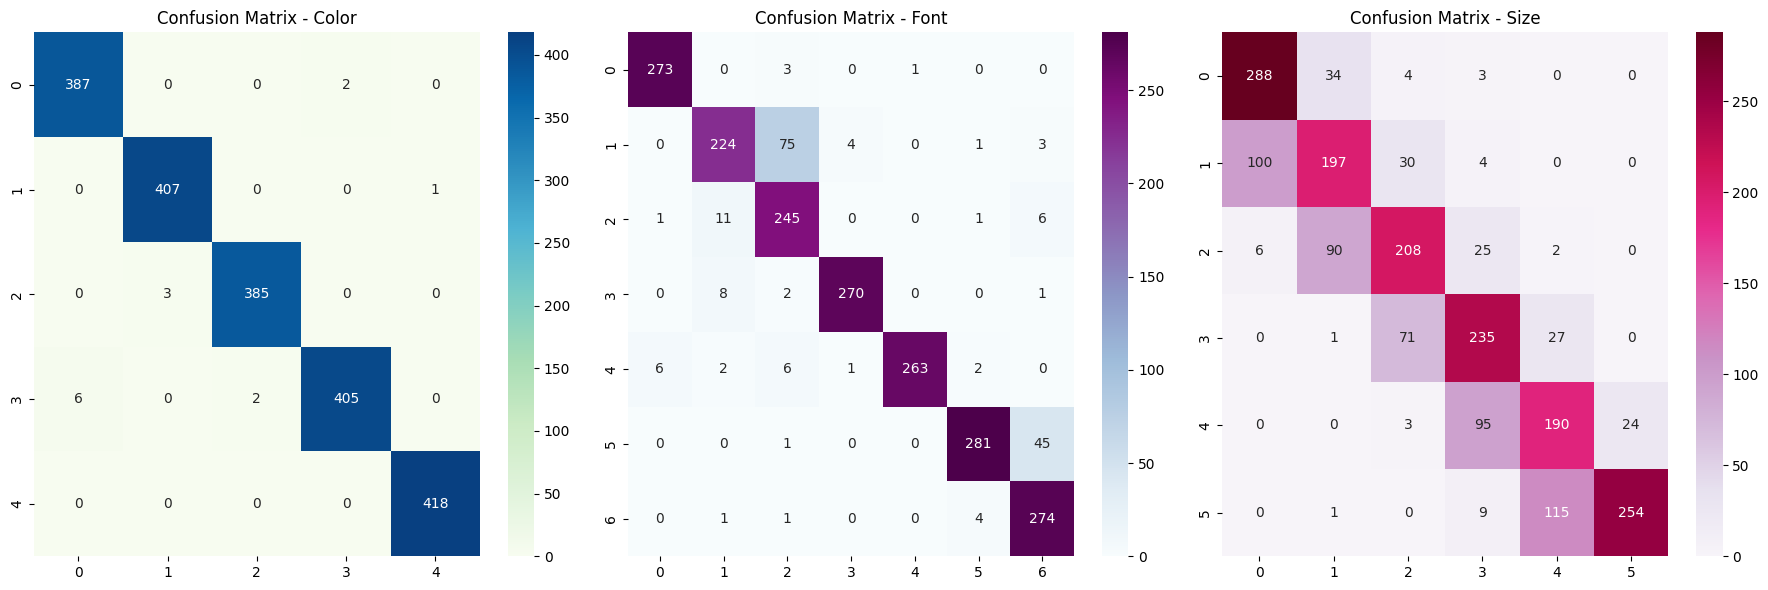

In [ ]:
plt.figure(figsize=(18, 6))

plt.subplot(131)
sns.heatmap(conf_matrix_color, annot=True, fmt='d', cmap='GnBu')
plt.title('Confusion Matrix - Color')

plt.subplot(132)
sns.heatmap(conf_matrix_font, annot=True, fmt='d', cmap='BuPu')
plt.title('Confusion Matrix - Font')

plt.subplot(133)
sns.heatmap(conf_matrix_size, annot=True, fmt='d', cmap='PuRd')
plt.title('Confusion Matrix - Size')

print("Classification Report - Color:\n", report_color)
print("Classification Report - Font:\n", report_font)
print("Classification Report - Size:\n", report_size)

plt.tight_layout()
plt.show()

In [ ]:
model = CustomVGG16(num_colors, num_fonts, num_sizes, h_dims_color=[256, 128, 128], h_dims_font=[1024, 512, 512],h_dims_size=[2024, 1024, 512])
model.load_state_dict(torch.load('/content/best_model.pth'))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

file_names, font_preds, size_preds, color_preds = [], [], [], []

submit_transform  = transforms.Compose([
          RemovedBackNoiseAndWhiteground(),
          BilateralFilter(d=9, sigmaColor=87.5, sigmaSpace=87.5),
          Sharpen(),
          transforms.CenterCrop((32, 480)),
          transforms.ToTensor()
          ])

csv_file = '/content/test.csv'
df = pd.read_csv(csv_file)

file_paths_from_csv = df.iloc[:, 0]

reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

with torch.no_grad():
    submit_bar = tqdm(file_paths_from_csv, desc=f'📄 Submitting...', unit='image')
    for img_path in submit_bar:

        if not os.path.exists(img_path):
            print(f"File {img_path} does not exist.")
            continue

        image = Image.open(img_path).convert('RGB')
        image = submit_transform(image)
        image = image.unsqueeze(0).to(device)

        color_output, font_output, size_output = model(image)

        color_pred = color_output.argmax(dim=1, keepdim=True).item()
        color_preds.append(f"#{reverse_color_mapping[color_pred]}")

        font_pred = font_output.argmax(dim=1, keepdim=True).item()
        font_preds.append(reverse_font_mapping[font_pred])

        size_pred = size_output.argmax(dim=1, keepdim=True).item()
        size_preds.append(reverse_font_size_mapping[size_pred])

        file_name = os.path.basename(img_path)
        file_names.append(f"images/{file_name}")

data = list(zip(file_names, font_preds, size_preds, color_preds))
submission_df = pd.DataFrame(data, columns=['image_path', 'font', 'font_size', 'color'])

output_path = '/content/WorkShopSubmission.csv'
submission_df.to_csv(output_path, index=False)

print(f"CSV file saved to {output_path}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
📄 Submitting...: 100%|██████████| 2520/2520 [00:22<00:00, 113.46image/s]

CSV file saved to /content/WorkShopSubmission.csv


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset, Dataset,random_split

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

from torch.utils.data import Dataset

import pandas as pd
import shutil

import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import models
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score, recall_score

import os
import cv2
from PIL import Image, ImageEnhance, ImageFilter
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report


!curl -L -o Font_recognition.zip https://github.com/NextGen-AI-Camp/curriculum/releases/download/Workshop/Font_recognition.zip
!unzip -o  /content/Font_recognition.zip

--

def process_csv(csv_path, images_folder, output_base_folder, has_labels=False):
    # อ่านไฟล์ CSV ที่มีข้อมูลภาพและรายละเอียดอื่นๆ ลงใน DataFrame
    df = pd.read_csv(csv_path)

    # ตรวจสอบว่ามีโฟลเดอร์ปลายทางหรือไม่ หากไม่มี ให้สร้างโฟลเดอร์นั้น
    if not os.path.exists(output_base_folder):
        os.makedirs(output_base_folder)

    # วนลูปผ่านแต่ละแถวใน DataFrame
    for index, row in df.iterrows():
        # ดึง path ของภาพจากคอลัมน์ 'image_path'
        image_path = row['image_path']

        # ถ้าตัวแปร has_labels เป็น True (หมายถึงมี label)
        if has_labels:
            # ดึงข้อมูลฟอนต์ ฟอนต์ไซต์ และสีจาก DataFrame ถ้าไม่มีข้อมูลให้ใช้ค่าเริ่มต้น
            font = row.get('font', 'unknown_font')
            font_size = row.get('font_size', 'unknown_size')
            color = row.get('color', 'unknown_color').replace("#", "")

            # สร้างเส้นทางโฟลเดอร์ปลายทางตามสี ฟอนต์ และขนาดฟอนต์
            class_folder = os.path.join(
                output_base_folder,
                color,
                font,
                f"size_{font_size}"
            )
            # ถ้าโฟลเดอร์ไม่อยู่ ให้สร้างโฟลเดอร์ใหม่ตามที่กำหนด
            if not os.path.exists(class_folder):
                os.makedirs(class_folder)
        else:
            # ถ้าไม่มี labels ให้ใช้โฟลเดอร์ปลายทางหลักที่ระบุ
            class_folder = output_base_folder

        # สร้าง path ของไฟล์ต้นทาง (ภาพ) และไฟล์ปลายทาง
        source = os.path.join(images_folder, os.path.basename(image_path))
        destination = os.path.join(class_folder, os.path.basename(image_path))

        # ตรวจสอบว่าไฟล์ต้นทาง (ภาพ) มีอยู่หรือไม่
        if os.path.exists(source):
            # คัดลอกไฟล์จากต้นทางไปยังปลายทาง
            shutil.copy2(source, destination)
        else:
            # ถ้าไฟล์ต้นทางไม่เจอ ให้แสดงข้อความแจ้งเตือน
            print(f"File {os.path.basename(image_path)} does not exist in {images_folder}")

# กำหนด path ของไฟล์ CSV สำหรับการฝึก (train)
train_csv_path = '/content/train.csv'
# กำหนด path ของไฟล์ CSV สำหรับการทดสอบ (test)
test_csv_path = '/content/test.csv'
# กำหนด path ของโฟลเดอร์ที่มีภาพต้นฉบับ
images_folder = '/content/images'

# กำหนด path ของโฟลเดอร์ปลายทางสำหรับภาพที่ถูกแยกตามข้อมูลการฝึก (train)
train_output_base_folder = '/content/train_pic'
# กำหนด path ของโฟลเดอร์ปลายทางสำหรับภาพที่ไม่มีการแยกตาม label (test)
test_output_base_folder = '/content/test_pic'

# เรียกฟังก์ชัน process_csv เพื่อประมวลผลข้อมูลการฝึก (มี labels)
process_csv(train_csv_path, images_folder, train_output_base_folder, has_labels=True)
# เรียกฟังก์ชัน process_csv เพื่อประมวลผลข้อมูลทดสอบ (ไม่มี labels)
process_csv(test_csv_path, images_folder, test_output_base_folder, has_labels=False)

--

class MultiAlphabetDataset(Dataset):  # สร้างคลาส MultiAlphabetDataset ซึ่งสืบทอดคุณสมบัติจากคลาส Dataset
    def __init__(self, root_dir, transform=None):
        # ฟังก์ชันเริ่มต้น (constructor) สำหรับการตั้งค่าค่าพารามิเตอร์เบื้องต้น
        self.root_dir = root_dir  # กำหนด root directory ที่เก็บข้อมูลของ dataset
        self.transform = transform  # กำหนด transformations ที่จะถูกนำมาใช้ในการแปลงภาพ
        self.samples = []  # สร้างลิสต์เปล่าสำหรับเก็บ path ของไฟล์ภาพและข้อมูลอื่น ๆ

        # สร้าง mapping สำหรับสี ให้แต่ละสีมีตัวเลขแทนค่าที่สอดคล้องกับสี
        self.color_mapping = {'FF6666': 0, '0000FF': 1, 'A020F0': 2, 'DF3030': 3, '26E953': 4}
        # สร้าง mapping สำหรับฟอนต์ ให้แต่ละฟอนต์มีตัวเลขแทนค่าที่สอดคล้องกับฟอนต์
        self.font_mapping = {'Athiti-Regular': 0, 'Sarabun-Regular': 1, 'NotoSerifThai-Regular': 2,
                             'Kodchasan-Regular': 3, 'Prompt-Regular': 4, 'KhaosuayThin': 5, 'FkBeautyRegular': 6}
        # สร้าง mapping สำหรับขนาดฟอนต์ ให้แต่ละขนาดมีตัวเลขแทนค่าที่สอดคล้องกับขนาด
        self.font_size_mapping = {18: 0, 20: 1, 22: 2, 24: 3, 26: 4, 28: 5}

        # วนลูปผ่านทุกโฟลเดอร์ย่อยใน root directory โดยแต่ละโฟลเดอร์เป็นสีของฟอนต์
        for color_dir in os.scandir(root_dir):
            if color_dir.is_dir():  # ตรวจสอบว่าโฟลเดอร์นี้เป็น directory หรือไม่
                color = color_dir.name  # เก็บชื่อของโฟลเดอร์ (ชื่อสี)
                # วนลูปผ่านทุกโฟลเดอร์ย่อยในโฟลเดอร์สี ซึ่งแต่ละโฟลเดอร์ย่อยนี้เป็นฟอนต์
                for font_dir in os.scandir(color_dir.path):
                    if font_dir.is_dir():  # ตรวจสอบว่าโฟลเดอร์นี้เป็น directory หรือไม่
                        font = font_dir.name  # เก็บชื่อของโฟลเดอร์ (ชื่อฟอนต์)
                        # วนลูปผ่านทุกโฟลเดอร์ย่อยในโฟลเดอร์ฟอนต์ ซึ่งแต่ละโฟลเดอร์ย่อยนี้เป็นขนาดฟอนต์
                        for size_dir in os.scandir(font_dir.path):
                            if size_dir.is_dir() and size_dir.name.startswith("size_"):  # ตรวจสอบว่าเป็น directory และชื่อขึ้นต้นด้วย "size_"
                                # แยกขนาดฟอนต์จากชื่อโฟลเดอร์ (หลัง "size_")
                                font_size = int(size_dir.name.split('_')[1])
                                # วนลูปผ่านทุกไฟล์ในโฟลเดอร์ขนาดฟอนต์ ซึ่งแต่ละไฟล์เป็นภาพ
                                for file in os.scandir(size_dir.path):
                                    if file.is_file():  # ตรวจสอบว่าไฟล์นี้เป็นไฟล์ (ไม่ใช่โฟลเดอร์)
                                        # เก็บ path ของไฟล์, ฟอนต์, ขนาดฟอนต์, และสี ลงในลิสต์ samples
                                        self.samples.append((file.path, font, font_size, color))

        # พิมพ์จำนวน samples ทั้งหมดที่พบ
        print(f"Total samples found: {len(self.samples)}")

    def __len__(self):
        # คืนค่าจำนวน samples ทั้งหมดใน dataset
        return len(self.samples)

    def __getitem__(self, idx):
        # ตรวจสอบว่า idx เป็น torch tensor หรือไม่ ถ้าใช่ให้แปลงเป็นลิสต์
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # ดึงข้อมูล path ของภาพ, ฟอนต์, ขนาดฟอนต์, และสี ตาม index ที่กำหนด
        img_path, font, font_size, color = self.samples[idx]
        # เปิดภาพจาก path ที่ดึงมา โดยแปลงเป็นโหมด 'RGB'
        image = Image.open(img_path).convert('RGB')

        # ถ้ามีการกำหนด transformations ให้ใช้ transformations นั้นแปลงภาพ
        if self.transform:
            image = self.transform(image)

        # แปลงข้อมูลฟอนต์เป็นตัวเลขที่สอดคล้องกับ mapping ที่สร้างไว้
        font_encoded = torch.tensor(self.font_mapping.get(font), dtype=torch.long)
        # แปลงข้อมูลขนาดฟอนต์เป็นตัวเลขที่สอดคล้องกับ mapping ที่สร้างไว้
        font_size_encoded = torch.tensor(self.font_size_mapping.get(font_size), dtype=torch.long)
        # แปลงข้อมูลสีเป็นตัวเลขที่สอดคล้องกับ mapping ที่สร้างไว้
        color_encoded = torch.tensor(self.color_mapping.get(color), dtype=torch.long)

        # คืนค่า (image, color_encoded, font_encoded, font_size_encoded) สำหรับการใช้งานในโมเดล
        return image, color_encoded, font_encoded, font_size_encoded

--

# คลาส Sharpen ใช้เพื่อเพิ่มความคมชัดของภาพ
class Sharpen(object):
    def __call__(self, img):
        # ใช้ ImageEnhance.Sharpness เพื่อเพิ่มความคมชัดของภาพ
        enhancer = ImageEnhance.Sharpness(img)
        # ปรับความคมชัดของภาพโดยเพิ่มขึ้น 5 เท่า
        return enhancer.enhance(5.0)

# คลาส BilateralFilter ใช้เพื่อใช้ฟิลเตอร์ Bilateral ในการลด noise โดยยังรักษาขอบของภาพ
class BilateralFilter(object):
    def __init__(self, d=9, sigmaColor=90, sigmaSpace=90):
        # กำหนดค่าเริ่มต้นสำหรับพารามิเตอร์ฟิลเตอร์ Bilateral
        self.d = d  # ขนาดของเนื้อที่ที่ใช้คำนวณฟิลเตอร์
        self.sigmaColor = sigmaColor  # กำหนดค่าความเบลอของสี
        self.sigmaSpace = sigmaSpace  # กำหนดค่าความเบลอของตำแหน่งในพื้นที่

    def __call__(self, img):
        # แปลงภาพจาก PIL เป็น NumPy array
        img_np = np.array(img)
        # ใช้ฟิลเตอร์ Bilateral เพื่อลด noise ในภาพ
        filtered_img_np = cv2.bilateralFilter(img_np, self.d, self.sigmaColor, self.sigmaSpace)
        # แปลงภาพจาก NumPy array กลับเป็นภาพ PIL
        filtered_img = Image.fromarray(filtered_img_np)
        return filtered_img  # คืนค่าภาพที่ผ่านการฟิลเตอร์แล้ว

# คลาส RemovedBackNoiseAndWhiteground ใช้ในการกำจัด noise และทำให้พื้นหลังเป็นสีขาว
class RemovedBackNoiseAndWhiteground:
    def __init__(self, threshold=(200, 200, 200)):
        # กำหนดค่า threshold เพื่อใช้ในการแยกแยะสีที่ต้องการทำให้เป็นสีขาว
        self.threshold = threshold

    def __call__(self, img):
        # แปลงภาพจาก PIL เป็น NumPy array
        img_np = np.array(img)
        # สร้าง mask เพื่อแยกแยะพิกเซลที่มีค่าสีเกิน threshold
        mask = (img_np[..., 0] >= self.threshold[0]) & \
               (img_np[..., 1] >= self.threshold[1]) & \
               (img_np[..., 2] >= self.threshold[2])
        # เปลี่ยนพิกเซลที่ตรงกับ mask ให้เป็นสีขาว
        img_np[mask] = [255, 255, 255]
        # แปลงภาพจาก NumPy array กลับเป็นภาพ PIL และคืนค่า
        return Image.fromarray(img_np)

# กำหนด transformations หลายตัวสำหรับการแปลงภาพก่อนใช้งานในโมเดล
transform = transforms.Compose([
    RemovedBackNoiseAndWhiteground(),  # กำจัด noise และทำให้พื้นหลังเป็นสีขาว
    BilateralFilter(d=9, sigmaColor=87.5, sigmaSpace=87.5),  # ใช้ฟิลเตอร์ Bilateral เพื่อลด noise
    Sharpen(),  # เพิ่มความคมชัดให้กับภาพ
    transforms.CenterCrop((32, 480)),  # ตัดภาพตรงกลางให้มีขนาด 32x480
    transforms.ToTensor()  # แปลงภาพให้เป็น Tensor สำหรับใช้งานใน PyTorch
])

# กำหนด root directory สำหรับ dataset
root_dir = '/content/train_pic'
# สร้าง dataset ด้วย MultiAlphabetDataset พร้อมกับ transformations ที่กำหนด
dataset = MultiAlphabetDataset(root_dir=root_dir, transform=transform)

# สร้าง dictionary สำหรับ map ค่า id ของสี ฟอนต์ และขนาดฟอนต์ กลับเป็นชื่อ
reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

# สร้าง dataloader สำหรับการโหลดข้อมูล batch ละ 4 ตัวอย่าง และสุ่มลำดับข้อมูล
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# ดึง batch แรกจาก dataloader
images, colors, fonts, font_sizes = next(iter(dataloader))

# แปลงค่าตัวเลขที่แทนสี ฟอนต์ และขนาดฟอนต์ กลับเป็นชื่อ
color_names = [reverse_color_mapping[int(color)] for color in colors]
font_names = [reverse_font_mapping[int(font)] for font in fonts]
font_size_names = [reverse_font_size_mapping[int(font_size)] for font_size in font_sizes]

# แสดงผลข้อมูล batch ของภาพ สี ฟอนต์ และขนาดฟอนต์
print(f"Batch Images Shape: {images.shape}")
print(f"Batch Colors: {color_names}")
print(f"Batch Fonts: {font_names}")
print(f"Batch Font Sizes: {font_size_names}")

--

def load_data(reverse=False, normalize=False, batch_size=32):
    # กำหนด root directory ที่ใช้เก็บ dataset ของรูปภาพ
    root_dir = '/content/train_pic'

    # กำหนด transformation สำหรับการแปลงภาพในขั้นตอนการฝึกโมเดล
    train_transform = transforms.Compose([
        RemovedBackNoiseAndWhiteground(),  # กำจัด noise และเปลี่ยนพื้นหลังให้เป็นสีขาว
        BilateralFilter(d=9, sigmaColor=87.5, sigmaSpace=87.5),  # ใช้ฟิลเตอร์ Bilateral เพื่อลด noise
        Sharpen(),  # เพิ่มความคมชัดให้กับภาพ
        transforms.CenterCrop((32, 480)),  # ตัดภาพตรงกลางให้มีขนาด 32x480
        transforms.ToTensor()  # แปลงภาพให้เป็น Tensor สำหรับใช้งานใน PyTorch
    ])

    # สร้าง dataset โดยใช้ MultiAlphabetDataset พร้อม transformation ที่กำหนด
    dataset = MultiAlphabetDataset(root_dir=root_dir, transform=train_transform)

    # คำนวณขนาดของ train dataset เป็น 80% ของ dataset ทั้งหมด
    train_size = int(0.8 * len(dataset))
    # คำนวณขนาดของ test dataset เป็นส่วนที่เหลือจาก train dataset
    test_size = len(dataset) - train_size

    # แบ่ง dataset เป็น train dataset และ test dataset โดยใช้ random_split
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # สร้าง DataLoader สำหรับ train dataset โดยกำหนด batch_size และ shuffle ข้อมูล
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # สร้าง DataLoader สำหรับ test dataset โดยกำหนด batch_size และไม่ shuffle ข้อมูล
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # คืนค่า DataLoader สำหรับ train และ test datasets
    return train_loader, test_loader

# เรียกใช้ฟังก์ชัน load_data เพื่อโหลด train และ test DataLoader
train_loader, test_loader = load_data(reverse=False, normalize=False, batch_size=32)

--

def get_dataset_stats(loader):
    # สร้าง dictionaries เพื่อเก็บจำนวนของฟอนต์, ขนาดฟอนต์, และสี
    font_count = {}
    font_size_count = {}
    color_count = {}
    total_samples = 0  # ตัวแปรสำหรับเก็บจำนวนตัวอย่างทั้งหมด

    # สร้าง mapping กลับ (reverse mapping) จากค่า index ไปยังค่าต้นฉบับ (เช่น ชื่อสี, ชื่อฟอนต์, ขนาดฟอนต์)
    reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
    reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
    reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

    # วนลูปผ่านแต่ละ batch ใน DataLoader
    for batch in loader:
        images, colors, fonts, font_sizes = batch  # แยกข้อมูล batch ออกเป็นภาพ, สี, ฟอนต์ และขนาดฟอนต์

        # แปลงค่า index ของสี ฟอนต์ และขนาดฟอนต์ กลับเป็นชื่อจริง โดยใช้ reverse mapping
        color_names = [reverse_color_mapping[int(color)] for color in colors]
        font_names = [reverse_font_mapping[int(font)] for font in fonts]
        font_size_names = [reverse_font_size_mapping[int(font_size)] for font_size in font_sizes]

        # นับจำนวนของแต่ละสีและเพิ่มค่าใน dictionary
        for color in color_names:
            if color not in color_count:
                color_count[color] = 0
            color_count[color] += 1

        # นับจำนวนของแต่ละฟอนต์และเพิ่มค่าใน dictionary
        for font in font_names:
            if font not in font_count:
                font_count[font] = 0
            font_count[font] += 1

        # นับจำนวนของแต่ละขนาดฟอนต์และเพิ่มค่าใน dictionary
        for font_size in font_size_names:
            if font_size not in font_size_count:
                font_size_count[font_size] = 0
            font_size_count[font_size] += 1

        # เพิ่มจำนวนตัวอย่างทั้งหมดใน batch นี้เข้ากับตัวแปร total_samples
        total_samples += len(images)

    # คืนค่า dictionaries ที่เก็บข้อมูลสถิติของฟอนต์, ขนาดฟอนต์, สี และจำนวนตัวอย่างทั้งหมด
    return font_count, font_size_count, color_count, total_samples

--

# เรียกใช้ฟังก์ชัน get_dataset_stats เพื่อนับจำนวนฟอนต์ ขนาดฟอนต์ สี และจำนวนทั้งหมดใน train_loader
train_font_count, train_font_size_count, train_color_count, train_total_samples = get_dataset_stats(train_loader)

# เรียกใช้ฟังก์ชัน get_dataset_stats เพื่อนับจำนวนฟอนต์ ขนาดฟอนต์ สี และจำนวนทั้งหมดใน test_loader
test_font_count, test_font_size_count, test_color_count, test_total_samples = get_dataset_stats(test_loader)

# แสดงข้อมูลเกี่ยวกับ train dataset
print("📃Train Dataset:")
# วนลูปผ่าน dictionary ที่เก็บจำนวนฟอนต์ใน train dataset และแสดงผลลัพธ์
for font, count in train_font_count.items():
    print(f"\tNumber of images with font {font}: {count}")
# วนลูปผ่าน dictionary ที่เก็บจำนวนขนาดฟอนต์ใน train dataset และแสดงผลลัพธ์
for font_size, count in train_font_size_count.items():
    print(f"\tNumber of images with font size {font_size}: {count}")
# วนลูปผ่าน dictionary ที่เก็บจำนวนสีใน train dataset และแสดงผลลัพธ์
for color, count in train_color_count.items():
    print(f"\tNumber of images with color {color}: {count}")
# แสดงจำนวนตัวอย่างทั้งหมดใน train dataset
print(f"\tNumber of training samples: {train_total_samples}")

# แสดงข้อมูลเกี่ยวกับ test dataset
print("📃Test Dataset:")
# วนลูปผ่าน dictionary ที่เก็บจำนวนฟอนต์ใน test dataset และแสดงผลลัพธ์
for font, count in test_font_count.items():
    print(f"\tNumber of images with font {font}: {count}")
# วนลูปผ่าน dictionary ที่เก็บจำนวนขนาดฟอนต์ใน test dataset และแสดงผลลัพธ์
for font_size, count in test_font_size_count.items():
    print(f"\tNumber of images with font size {font_size}: {count}")
# วนลูปผ่าน dictionary ที่เก็บจำนวนสีใน test dataset และแสดงผลลัพธ์
for color, count in test_color_count.items():
    print(f"\tNumber of images with color {color}: {count}")
# แสดงจำนวนตัวอย่างทั้งหมดใน test dataset
print(f"\tNumber of testing samples: {test_total_samples}")

--

# กำหนดขนาด batch ที่ต้องการสำหรับการแสดงภาพ
batch_size = 32

# ดึง batch แรกจาก train_loader โดยใช้ iter เพื่อแปลง train_loader ให้เป็น iterator
images, colors, fonts, font_sizes = next(iter(train_loader))

# สร้าง dictionary สำหรับ mapping จากค่าที่เข้ารหัสกลับไปเป็นค่าต้นฉบับ เช่น สี ฟอนต์ และขนาดฟอนต์
reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

# กำหนดรูปแบบกราฟให้เป็น grid ขนาด 8x4 (8 แถว 4 คอลัมน์) โดยแต่ละ subplot มีขนาด 15x24 นิ้ว
fig, axes = plt.subplots(8, 4, figsize=(15, 24))
# แปลง axes ให้เป็น array แบบ 1 มิติ เพื่อง่ายต่อการวนลูป
axes = axes.flatten()

# วนลูปผ่านข้อมูลของแต่ละรูปภาพใน batch ตามค่า batch_size ที่กำหนด (32 รูปภาพ)
for idx, (img, color, font, font_size) in enumerate(zip(images[:batch_size], colors[:batch_size], fonts[:batch_size], font_sizes[:batch_size])):
    # กำหนดตำแหน่งของ subplot ที่ต้องการแสดงรูปภาพ
    ax = axes[idx]

    # แปลงรูปภาพจาก tensor (C, H, W) ไปเป็น numpy array (H, W, C) เพื่อแสดงผลด้วย matplotlib
    img_np = img.permute(1, 2, 0).numpy()

    # แปลงค่าที่เข้ารหัสกลับไปเป็นชื่อสี ฟอนต์ และขนาดฟอนต์จริงโดยใช้ reverse mapping ที่สร้างไว้
    color_name = reverse_color_mapping[int(color)]
    font_name = reverse_font_mapping[int(font)]
    font_size_value = reverse_font_size_mapping[int(font_size)]

    # แสดงรูปภาพใน subplot นั้น ๆ
    ax.imshow(img_np)
    # ตั้งชื่อ title ของ subplot นั้นให้แสดงฟอนต์ ขนาดฟอนต์ และสี
    ax.set_title(f"Font: {font_name}\nSize: {font_size_value}\nColor: {color_name}")
    # ซ่อนแกน x และ y เพื่อไม่ให้แสดงกรอบรอบภาพ
    ax.axis('off')

# สำหรับ subplot ที่ไม่ได้ใช้งาน (กรณีมีน้อยกว่า batch_size) ซ่อนแกนของ subplot เหล่านั้น
for ax in axes[len(images[:batch_size]):]:
    ax.axis('off')

# ปรับแต่ง layout ของกราฟเพื่อไม่ให้กรอบชนกัน โดยกำหนด padding ระหว่าง subplot เป็น 2.0
plt.tight_layout(pad=2.0)
# แสดงผลกราฟทั้งหมด
plt.show()

--

# โหลดโมเดล VGG16 ที่ถูกฝึกมาแล้ว (pretrained) พร้อม weight เริ่มต้น
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# กำหนด class สำหรับโมเดลที่ custom จาก nn.Module
class CustomVGG16(nn.Module):
    def __init__(self,
                 num_colors=5,            # จำนวนคลาสสี (ค่าเริ่มต้นคือ 5)
                 num_fonts=7,             # จำนวนคลาสฟอนต์ (ค่าเริ่มต้นคือ 7)
                 num_sizes=6,             # จำนวนคลาสขนาดฟอนต์ (ค่าเริ่มต้นคือ 6)
                 h_dims_color=[256, 128, 128],   # ขนาดของ hidden layers ใน color classifier
                 h_dims_font=[1024, 512, 512],   # ขนาดของ hidden layers ใน font classifier
                 h_dims_size=[2024, 1024, 512],  # ขนาดของ hidden layers ใน size classifier
                 input_size=(3, 32, 480)):       # ขนาดของ input ที่จะส่งเข้าโมเดล
        super(CustomVGG16, self).__init__()      # เรียกใช้ตัว constructor ของ nn.Module

        # โหลดโมเดล VGG16 ที่ pretrained มาแล้ว
        self.vgg16 = models.vgg16(pretrained=True)

        # เพิ่ม layer Flatten เพื่อทำให้ output ของ convolutional layers เป็นแบบ flat (1D)
        self.vgg16.flatten = nn.Flatten()

        # ทำการ unfreeze พารามิเตอร์ในส่วนของ feature extraction ของ VGG16 เพื่อให้เรียนรู้ได้
        for param in self.vgg16.features.parameters():
            param.requires_grad = True

        # ทำการ unfreeze พารามิเตอร์ในส่วนของ classifier ของ VGG16 เพื่อให้เรียนรู้ได้
        for param in self.vgg16.classifier.parameters():
            param.requires_grad = True

        # สร้างตัวแปร classifier เก็บโครงสร้าง layer สำหรับ custom classifier
        classifier = []
        # กำหนด input size ของ fully connected layer โดยใช้ฟังก์ชัน _get_input_size_fc
        in_features = self._get_input_size_fc(input_size)

        # สร้าง color classifier ด้วย hidden dimensions และจำนวนคลาสที่กำหนด
        self.color_classifier = self._create_classifier(in_features, h_dims_color, num_colors)
        # สร้าง font classifier ด้วย hidden dimensions และจำนวนคลาสที่กำหนด
        self.font_classifier = self._create_classifier(in_features, h_dims_font, num_fonts)
        # สร้าง size classifier ด้วย hidden dimensions และจำนวนคลาสที่กำหนด
        self.size_classifier = self._create_classifier(in_features, h_dims_size, num_sizes)

    # ฟังก์ชันนี้ใช้ในการคำนวณขนาดของ input ที่จะเข้าสู่ fully connected layer
    def _get_input_size_fc(self, input_shape):
        with torch.no_grad():                          # ปิดการคำนวณ gradient เพื่อประหยัดหน่วยความจำ
            dummy_input = torch.zeros(1, *input_shape) # สร้าง dummy input ขนาดเดียวกับ input จริง
            x = self.vgg16.features(dummy_input)       # ส่ง dummy input ผ่าน feature extraction ของ VGG16
            x = self.vgg16.avgpool(x)                  # ส่งผ่าน average pooling layer ของ VGG16
            x = self.vgg16.flatten(x)                  # ทำให้ output เป็นแบบ 1D
            return x.shape[-1]                         # คืนค่าขนาดของ feature map ที่ flatten แล้ว

    # ฟังก์ชันนี้สร้าง classifier ด้วย hidden layers และจำนวนคลาสที่กำหนด
    def _create_classifier(self, in_features, h_dims, num_classes):
        layers = []                                   # เริ่มต้นด้วยลิสต์ว่าง
        for hdim in h_dims:                           # สำหรับแต่ละ hidden dimension ใน h_dims
            layers.append(nn.Linear(in_features, hdim)) # เพิ่ม fully connected layer
            layers.append(nn.ReLU(inplace=True))        # เพิ่ม ReLU activation function
            layers.append(nn.Dropout(p=0.5))            # เพิ่ม Dropout เพื่อป้องกัน overfitting
            in_features = hdim                         # อัพเดตขนาดของ input สำหรับ layer ถัดไป
        layers.append(nn.Linear(in_features, num_classes)) # เพิ่ม output layer ด้วยจำนวนคลาสที่กำหนด
        return nn.Sequential(*layers)                  # คืนค่า Sequential model ที่สร้างขึ้น

    # ฟังก์ชัน forward สำหรับการประมวลผลข้อมูล
    def forward(self, x):
        x = self.vgg16.features(x)   # ส่ง input ผ่าน feature extraction ของ VGG16
        x = self.vgg16.avgpool(x)    # ส่งผ่าน average pooling layer
        x = self.vgg16.flatten(x)    # ทำให้ feature map เป็นแบบ 1D

        # ส่ง feature ที่ได้ผ่าน color classifier, font classifier และ size classifier
        color_output = self.color_classifier(x)
        font_output = self.font_classifier(x)
        size_output = self.size_classifier(x)

        # คืนค่า output ทั้งสามสำหรับสี ฟอนต์ และขนาด
        return color_output, font_output, size_output


# กำหนดค่าจำนวนคลาสของสีเป็น 5
num_colors = 5

# กำหนดค่าจำนวนคลาสของฟอนต์เป็น 7
num_fonts = 7

# กำหนดค่าจำนวนคลาสของขนาดฟอนต์เป็น 6
num_sizes = 6

# สร้างอินสแตนซ์ของโมเดล CustomVGG16 โดยใช้ค่าพารามิเตอร์ตามที่กำหนด
model = CustomVGG16(
    num_colors,             # ส่งค่า num_colors ที่กำหนด (5) เข้าไปในโมเดล
    num_fonts,              # ส่งค่า num_fonts ที่กำหนด (7) เข้าไปในโมเดล
    num_sizes,              # ส่งค่า num_sizes ที่กำหนด (6) เข้าไปในโมเดล
    h_dims_color=[256, 128, 128],   # กำหนด hidden layers ของ color classifier ด้วยขนาด 256, 128 และ 128
    h_dims_font=[1024, 512, 512],   # กำหนด hidden layers ของ font classifier ด้วยขนาด 1024, 512 และ 512
    h_dims_size=[2024, 1024, 512]   # กำหนด hidden layers ของ size classifier ด้วยขนาด 2024, 1024 และ 512
)

# โมเดลที่ถูกสร้างขึ้นนี้จะใช้โครงสร้างของ VGG16 ที่ pretrained มาแล้ว และเพิ่ม classifier สำหรับการจำแนกสี ฟอนต์ และขนาดของฟอนต์
# โดยตัว classifier แต่ละตัวจะมีโครงสร้าง fully connected layers ที่แตกต่างกันตาม hidden dimensions ที่ระบุ

--

# กำหนดตัวแปรเพื่อเก็บคะแนนที่ดีที่สุด (best_score) เริ่มต้นเป็น 0.0
best_score = 0.0

# ฟังก์ชันสำหรับการคำนวณค่า F-beta score โดยใช้ค่า precision, recall และ beta
def calculate_fbeta_score(precision, recall, beta):
    beta_squared = beta ** 2                # คำนวณ beta ยกกำลังสอง
    return (1 + beta_squared) * (precision * recall) / ((beta_squared * precision) + recall + 1e-7)  # สูตรในการคำนวณ F-beta score

# ฟังก์ชันสำหรับการเทรนโมเดล
def train(model,
          optimizer,          # ออพติไมเซอร์ที่ใช้ในการปรับค่าพารามิเตอร์
          train_loader,       # data loader สำหรับข้อมูลเทรน
          test_loader,        # data loader สำหรับข้อมูลทดสอบ
          epochs=10,          # จำนวน epochs (ค่าเริ่มต้นคือ 10)
          beta=2,             # ค่า beta สำหรับ F-beta score (ค่าเริ่มต้นคือ 2)
          checkpoint_path=None, # เส้นทางสำหรับบันทึกโมเดล
          device='cpu'):      # อุปกรณ์ที่ใช้ (CPU หรือ GPU)

    global best_score          # ใช้ตัวแปร best_score ที่ประกาศภายนอกฟังก์ชัน
    model = model.to(device)   # ส่งโมเดลไปยัง device (เช่น ส่งไปยัง GPU ถ้ามี)
    print("🤖 Training on", device)  # แสดงข้อความว่าเทรนโมเดลอยู่บนอุปกรณ์ใด

    # ใช้ learning rate scheduler แบบ Cosine Annealing เพื่อปรับ learning rate ในระหว่างการเทรน
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # เริ่มต้นการเทรนโมเดล โดยใช้จำนวน epochs ที่กำหนด
    for epoch in range(epochs):
        model.train()           # ตั้งโมเดลเป็นโหมดเทรน

        # กำหนด loss function เป็น CrossEntropyLoss
        cross_entropy_loss = nn.CrossEntropyLoss()

        # แสดงแถบความก้าวหน้า (progress bar) สำหรับการเทรนในแต่ละ epoch
        train_bar = tqdm(train_loader,
                         desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]',
                         unit='batch')

        # วนลูปในแต่ละ batch ของข้อมูลการเทรน
        for batch_idx, (data, color_target, font_target, size_target) in enumerate(train_bar):
            # ส่งข้อมูลและ target ไปยังอุปกรณ์ที่ใช้งาน (เช่น GPU)
            data, color_target, font_target, size_target = data.to(device), color_target.to(device), font_target.to(device), size_target.to(device)

            optimizer.zero_grad()  # รีเซ็ต gradient ของ optimizer ให้เป็นศูนย์ก่อนการคำนวณครั้งถัดไป

            # ส่งข้อมูลเข้าโมเดลเพื่อให้โมเดลพยากรณ์ (predict) ผลลัพธ์
            color_output, font_output, size_output = model(data)

            # คำนวณ loss สำหรับแต่ละ output (สี, ฟอนต์, ขนาด)
            loss_color = cross_entropy_loss(color_output, color_target)
            loss_font = cross_entropy_loss(font_output, font_target)
            loss_size = cross_entropy_loss(size_output, size_target)

            # รวม loss ทั้งหมดเข้าด้วยกัน โดยกำหนด weight ของแต่ละ loss
            loss = (loss_color*1.0 + loss_font*1.3 + loss_size*1.5)

            # ย้อนกลับ gradient เพื่อทำการปรับค่าพารามิเตอร์
            loss.backward()
            optimizer.step()    # อัปเดตพารามิเตอร์ของโมเดลตาม optimizer ที่กำหนด

            # อัปเดตแถบ progress bar โดยแสดงค่าของ loss ในแต่ละ batch
            train_bar.set_postfix(loss=loss.item())

        model.eval()              # ตั้งโมเดลเป็นโหมดทดสอบ
        scheduler.step()          # อัปเดตค่า learning rate ตาม scheduler

        # กำหนดตัวแปรสำหรับนับจำนวนการทำนายที่ถูกต้องในแต่ละประเภท (สี, ฟอนต์, ขนาด)
        correct_color, correct_font, correct_size = 0, 0, 0
        test_loss_color, test_loss_font, test_loss_size = 0, 0, 0

        # ลิสต์สำหรับเก็บผลการพยากรณ์และ target เพื่อใช้ในการคำนวณคะแนนต่างๆ
        all_color_preds, all_color_targets = [], []
        all_font_preds, all_font_targets = [], []
        all_size_preds, all_size_targets = [], []

        # ปิดการคำนวณ gradient สำหรับช่วงทดสอบ
        with torch.no_grad():
            # แสดงแถบ progress bar สำหรับการทดสอบ
            test_bar = tqdm(test_loader,
                            desc=f"🧪 Testing Epoch [{epoch+1}/{epochs}]",
                            unit='batch')

            # วนลูปในแต่ละ batch ของข้อมูลทดสอบ
            for data, color_target, font_target, size_target in test_bar:
                data, color_target, font_target, size_target = data.to(device), color_target.to(device), font_target.to(device), size_target.to(device)

                # ส่งข้อมูลเข้าโมเดลและทำนายผลลัพธ์
                color_output, font_output, size_output = model(data)

                # คำนวณ test loss สำหรับแต่ละประเภท
                test_loss_color += cross_entropy_loss(color_output, color_target).item()
                test_loss_font += cross_entropy_loss(font_output, font_target).item()
                test_loss_size += cross_entropy_loss(size_output, size_target).item()

                # นำผลลัพธ์ที่พยากรณ์ได้มาเปรียบเทียบกับ target
                color_pred = color_output.argmax(dim=1, keepdim=True)
                font_pred = font_output.argmax(dim=1, keepdim=True)
                size_pred = size_output.argmax(dim=1, keepdim=True)

                # นับจำนวนการทำนายที่ถูกต้อง
                correct_color += color_pred.eq(color_target.view_as(color_pred)).sum().item()
                correct_font += font_pred.eq(font_target.view_as(font_pred)).sum().item()
                correct_size += size_pred.eq(size_target.view_as(size_pred)).sum().item()

                # เก็บผลการพยากรณ์และ target สำหรับคำนวณคะแนน F-beta
                all_color_preds.extend(color_pred.cpu().numpy())
                all_color_targets.extend(color_target.cpu().numpy())
                all_font_preds.extend(font_pred.cpu().numpy())
                all_font_targets.extend(font_target.cpu().numpy())
                all_size_preds.extend(size_pred.cpu().numpy())
                all_size_targets.extend(size_target.cpu().numpy())

            # คำนวณค่าเฉลี่ยของ loss ต่อจำนวนข้อมูลทดสอบ
            test_loss_color /= len(test_loader.dataset)
            test_loss_font /= len(test_loader.dataset)
            test_loss_size /= len(test_loader.dataset)

            # คำนวณความแม่นยำ (accuracy) ในการทำนายแต่ละประเภท
            accuracy_color = 100. * correct_color / len(test_loader.dataset)
            accuracy_font = 100. * correct_font / len(test_loader.dataset)
            accuracy_size = 100. * correct_size / len(test_loader.dataset)

            # คำนวณ precision และ recall สำหรับแต่ละประเภท (สี, ฟอนต์, ขนาด)
            precision_color = precision_score(all_color_targets, all_color_preds, average='weighted')
            recall_color = recall_score(all_color_targets, all_color_preds, average='weighted')
            precision_font = precision_score(all_font_targets, all_font_preds, average='weighted')
            recall_font = recall_score(all_font_targets, all_font_preds, average='weighted')
            precision_size = precision_score(all_size_targets, all_size_preds, average='weighted')
            recall_size = recall_score(all_size_targets, all_size_preds, average='weighted')

            # คำนวณ F-beta score สำหรับแต่ละประเภท
            fbeta_color = calculate_fbeta_score(precision_color, recall_color, beta)
            fbeta_font = calculate_fbeta_score(precision_font, recall_font, beta)
            fbeta_size = calculate_fbeta_score(precision_size, recall_size, beta)

            # คำนวณค่า F-beta score รวม โดยให้ weight แต่ละประเภทต่างกัน
            fbeta_total = (fbeta_font * 0.3) + (fbeta_color * 0.2) + (fbeta_size * 0.5)

            # แสดงผลการทดสอบในแต่ละ epoch
            print(f'Test set:')
            print(f'Average Color loss: {test_loss_color:.4f},🌈 Accuracy: {accuracy_color:.2f}%')
            print(f'Average Font loss: {test_loss_font:.4f},🔤 Accuracy: {accuracy_font:.2f}%')
            print(f'Average Size loss: {test_loss_size:.4f},🔢 Accuracy: {accuracy_size:.2f}%')
            print(f'F-beta Score (Color): {fbeta_color:.4f}, F-beta Score (Font): {fbeta_font:.4f}, F-beta Score (Size): {fbeta_size:.4f}')
            print(f'💡 Real Score (Total F-beta): {fbeta_total:.4f}')

            # ถ้า F-beta score ที่ได้ดีกว่า best score ที่มีอยู่ ก็ทำการบันทึกโมเดล
            if fbeta_total > best_score:
                best_score = fbeta_total
                if checkpoint_path:  # ถ้ามีเส้นทางบันทึกโมเดลที่กำหนดไว้
                    torch.save(model.state_dict(), checkpoint_path)  # บันทึกสถานะของโมเดล
                    print(f'# 🧠 Best model saved with F-beta Score: {fbeta_total:.4f} at epoch {epoch+1} 🧠')

--

# สร้างอินสแตนซ์ของโมเดล CustomVGG16 โดยกำหนดจำนวนคลาสและ hidden dimensions ตามที่ระบุ
model = CustomVGG16(
    num_colors,               # จำนวนคลาสของสี
    num_fonts,                # จำนวนคลาสของฟอนต์
    num_sizes,                # จำนวนคลาสของขนาดฟอนต์
    h_dims_color=[256, 128, 128],   # ขนาดของ hidden layers สำหรับ color classifier
    h_dims_font=[1024, 512, 512],   # ขนาดของ hidden layers สำหรับ font classifier
    h_dims_size=[2024, 1024, 512]   # ขนาดของ hidden layers สำหรับ size classifier
)

# สร้างออพติไมเซอร์ AdamW เพื่อใช้ในการอัปเดตค่าพารามิเตอร์ของโมเดล
# ใช้ค่า learning rate เท่ากับ 0.0000875 และ weight decay 1e-4 เพื่อป้องกัน overfitting
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0000875, weight_decay=1e-4)

# กำหนด learning rate scheduler แบบ Cosine Annealing เพื่อปรับ learning rate แบบลดลงเรื่อย ๆ
# T_max=100 หมายถึงจะค่อย ๆ ลดค่า learning rate จนกว่าจะครบ 100 epoch
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

# กำหนดอุปกรณ์ที่ใช้ในการเทรนโมเดล โดยจะใช้ GPU ถ้ามีอยู่ในระบบ (torch.cuda.is_available())
# ถ้าไม่มีก็จะใช้ CPU แทน
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# เรียกใช้ฟังก์ชัน train เพื่อเริ่มต้นการฝึกโมเดล
train(
    model=model,               # โมเดล CustomVGG16 ที่สร้างขึ้นมา
    optimizer=optimizer,       # ออพติไมเซอร์ AdamW ที่กำหนดไว้
    train_loader=train_loader, # train_loader ที่เก็บข้อมูลการเทรน
    test_loader=test_loader,   # test_loader ที่เก็บข้อมูลการทดสอบ
    epochs=100,                # กำหนดจำนวน epoch ที่ใช้ในการเทรน (100 รอบ)
    beta=2,                    # ใช้ beta = 2 ในการคำนวณค่า F-beta score
    checkpoint_path="/content/best_model.pth",  # เส้นทางสำหรับบันทึกโมเดลที่มีผลการทดสอบดีที่สุด
    device=device              # ส่งโมเดลไปยังอุปกรณ์ (GPU หรือ CPU)
)

# แสดงผลลัพธ์คะแนนที่ดีที่สุดหลังการฝึกโมเดลเสร็จสิ้น
print(f"😎 Best Score is {best_score:.4f}")  # แสดงคะแนน best_score ที่บันทึกไว้

--

# สร้าง class FeatureExtractor ที่สืบทอดมาจาก nn.Module สำหรับการดึง feature จาก layer ของโมเดล
class FeatureExtractor(nn.Module):

    # ฟังก์ชัน constructor ที่ใช้ในการกำหนดโมเดลและ target layers ที่ต้องการดึง feature
    def __init__(self, model, target_layers):
        super(FeatureExtractor, self).__init__()  # เรียกใช้ constructor ของ nn.Module
        self.model = model                        # เก็บโมเดลที่ต้องการดึง feature
        self.target_layers = target_layers        # เก็บรายชื่อ layers ที่ต้องการดึง feature
        self.features = []                        # สร้างลิสต์เปล่าสำหรับเก็บ feature จากแต่ละ layer

        # วนลูปผ่านทุก module (layer) ในโมเดลที่เราส่งเข้ามา
        for layer_name, layer in self.model.named_modules():
            # ถ้า layer ปัจจุบันอยู่ใน target_layers ที่เรากำหนดไว้
            if layer_name in target_layers:
                print(layer_name)  # แสดงชื่อของ layer ที่ต้องการดึง feature
                # ลงทะเบียน forward hook กับ layer โดยเรียกใช้ฟังก์ชัน save_feature
                layer.register_forward_hook(self.save_feature(layer_name))

    # ฟังก์ชันที่ใช้ในการบันทึก feature ของ layer ที่ต้องการ
    def save_feature(self, layer_name):
        # hook คือฟังก์ชันที่ใช้ใน forward pass เพื่อดึง output ของ layer ที่ต้องการ
        def hook(module, input, output):
            # บันทึก output ของ layer ที่ต้องการในลิสต์ features
            self.features.append(output.clone())  # clone เพื่อป้องกันไม่ให้ข้อมูลถูกแก้ไขภายหลัง
        return hook  # คืนค่าฟังก์ชัน hook

    # ฟังก์ชัน forward สำหรับการส่งข้อมูลผ่านโมเดล
    def forward(self, x):
        self.features = []  # รีเซ็ตลิสต์ features ทุกครั้งที่ทำการ forward
        self.model(x)       # ส่งข้อมูล x ผ่านโมเดล
        return self.features  # คืนค่าลิสต์ features ที่ได้จาก target layers

# สร้างลิสต์ชื่อ layers ที่ต้องการดึง feature โดยค้นหาจาก named_modules ของโมเดล
targets = [name for name, _ in model.named_modules() if 'features.' in name]
targets  # แสดงผลรายชื่อของ target layers ที่ต้องการ

--

# ตรวจสอบว่าเราสามารถใช้งาน GPU ได้หรือไม่ ถ้าได้ก็ใช้ 'cuda' ถ้าไม่ได้ก็ใช้ 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# สร้างโมเดล CustomVGG16 โดยกำหนด hidden dimensions สำหรับแต่ละ classifier
model = CustomVGG16(
    h_dims_color=[256, 128, 128],    # Hidden dimensions สำหรับ color classifier
    h_dims_font=[1024, 512, 512],    # Hidden dimensions สำหรับ font classifier
    h_dims_size=[2024, 1024, 512]    # Hidden dimensions สำหรับ size classifier
)

# โหลดน้ำหนักที่บันทึกไว้จากไฟล์ 'best_model.pth' ลงในโมเดล
model.load_state_dict(torch.load('/content/best_model.pth'))

# ส่งโมเดลไปยังอุปกรณ์ที่ใช้งาน (GPU หรือ CPU)
model.to(device)

# ตั้งโมเดลเป็นโหมดประเมินผล (evaluation mode) เพื่อปิดการคำนวณ gradient
model.eval()

# สร้างลิสต์เปล่าสำหรับเก็บผลลัพธ์ที่พยากรณ์ได้และผลลัพธ์จริงของแต่ละ classifier (color, font, size)
all_color_preds, all_color_targets = [], []  # ลิสต์สำหรับเก็บการพยากรณ์และ target ของสี
all_font_preds, all_font_targets = [], []    # ลิสต์สำหรับเก็บการพยากรณ์และ target ของฟอนต์
all_size_preds, all_size_targets = [], []    # ลิสต์สำหรับเก็บการพยากรณ์และ target ของขนาดฟอนต์

# ปิดการคำนวณ gradient ในช่วงการประเมินผลเพื่อประหยัดหน่วยความจำและเพิ่มความเร็ว
with torch.no_grad():
    # วนลูปผ่านข้อมูลทดสอบ (test_loader) เพื่อประเมินผลลัพธ์
    for data, color_target, font_target, size_target in test_loader:
        # ส่งข้อมูลและ target ไปยังอุปกรณ์ (GPU หรือ CPU)
        data = data.to(device)
        color_target, font_target, size_target = color_target.to(device), font_target.to(device), size_target.to(device)

        # ส่งข้อมูลเข้าโมเดลและทำการพยากรณ์ผลลัพธ์สำหรับสี, ฟอนต์ และขนาด
        color_output, font_output, size_output = model(data)

        # เลือกค่าพยากรณ์ที่มีความน่าจะเป็นสูงที่สุด (argmax) สำหรับแต่ละประเภท
        color_preds = color_output.argmax(dim=1, keepdim=True)
        font_preds = font_output.argmax(dim=1, keepdim=True)
        size_preds = size_output.argmax(dim=1, keepdim=True)

        # เก็บผลการพยากรณ์และผลลัพธ์จริง (target) ในลิสต์สำหรับแต่ละประเภท
        all_color_preds.extend(color_preds.cpu().numpy())      # เก็บผลลัพธ์การพยากรณ์ของสี
        all_color_targets.extend(color_target.cpu().numpy())   # เก็บ target จริงของสี
        all_font_preds.extend(font_preds.cpu().numpy())        # เก็บผลลัพธ์การพยากรณ์ของฟอนต์
        all_font_targets.extend(font_target.cpu().numpy())     # เก็บ target จริงของฟอนต์
        all_size_preds.extend(size_preds.cpu().numpy())        # เก็บผลลัพธ์การพยากรณ์ของขนาด
        all_size_targets.extend(size_target.cpu().numpy())     # เก็บ target จริงของขนาด

# คำนวณ confusion matrix สำหรับแต่ละประเภท
conf_matrix_color = confusion_matrix(all_color_targets, all_color_preds)  # confusion matrix สำหรับสี
conf_matrix_font = confusion_matrix(all_font_targets, all_font_preds)     # confusion matrix สำหรับฟอนต์
conf_matrix_size = confusion_matrix(all_size_targets, all_size_preds)     # confusion matrix สำหรับขนาดฟอนต์

# สร้าง classification report สำหรับแต่ละประเภท โดยให้ข้อมูลของ precision, recall, f1-score และอื่น ๆ
report_color = classification_report(all_color_targets, all_color_preds)  # classification report สำหรับสี
report_font = classification_report(all_font_targets, all_font_preds)     # classification report สำหรับฟอนต์
report_size = classification_report(all_size_targets, all_size_preds)     # classification report สำหรับขนาดฟอนต์

--

# สร้างรูปภาพใหม่ด้วยขนาด 18x6 หน่วย (ฟังก์ชันจาก matplotlib)
plt.figure(figsize=(18, 6))

# สร้าง subplot ที่ 1 สำหรับแสดง heatmap ของ confusion matrix สำหรับสี
plt.subplot(131)  # สร้าง subplot ลำดับที่ 1 ในกริด 1 แถว 3 คอลัมน์
sns.heatmap(conf_matrix_color, annot=True, fmt='d', cmap='GnBu')  # วาด heatmap ของ confusion matrix สำหรับสี, กำหนดให้แสดงค่าในแต่ละช่อง (annot=True), ใช้สี GnBu
plt.title('Confusion Matrix - Color')  # ตั้งชื่อให้กับกราฟว่า 'Confusion Matrix - Color'

# สร้าง subplot ที่ 2 สำหรับแสดง heatmap ของ confusion matrix สำหรับฟอนต์
plt.subplot(132)  # สร้าง subplot ลำดับที่ 2 ในกริด 1 แถว 3 คอลัมน์
sns.heatmap(conf_matrix_font, annot=True, fmt='d', cmap='BuPu')  # วาด heatmap ของ confusion matrix สำหรับฟอนต์, ใช้สี BuPu
plt.title('Confusion Matrix - Font')  # ตั้งชื่อให้กับกราฟว่า 'Confusion Matrix - Font'

# สร้าง subplot ที่ 3 สำหรับแสดง heatmap ของ confusion matrix สำหรับขนาด
plt.subplot(133)  # สร้าง subplot ลำดับที่ 3 ในกริด 1 แถว 3 คอลัมน์
sns.heatmap(conf_matrix_size, annot=True, fmt='d', cmap='PuRd')  # วาด heatmap ของ confusion matrix สำหรับขนาดฟอนต์, ใช้สี PuRd
plt.title('Confusion Matrix - Size')  # ตั้งชื่อให้กับกราฟว่า 'Confusion Matrix - Size'

# แสดง classification report สำหรับการพยากรณ์สี
print("Classification Report - Color:\n", report_color)  # แสดง classification report สำหรับสี

# แสดง classification report สำหรับการพยากรณ์ฟอนต์
print("Classification Report - Font:\n", report_font)  # แสดง classification report สำหรับฟอนต์

# แสดง classification report สำหรับการพยากรณ์ขนาดฟอนต์
print("Classification Report - Size:\n", report_size)  # แสดง classification report สำหรับขนาดฟอนต์

# ปรับ layout ของกราฟทั้งหมดให้พอดีกับพื้นที่ที่กำหนด
plt.tight_layout()

# แสดงกราฟทั้งหมดบนหน้าจอ
plt.show()

--

# กำหนดโมเดลชื่อ CustomVGG16 โดยมีพารามิเตอร์จำนวนสี จำนวนฟอนต์ และขนาดฟอนต์ รวมถึงขนาดของ hidden layers สำหรับแต่ละการคาดการณ์
model = CustomVGG16(num_colors, num_fonts, num_sizes,
                    h_dims_color=[256, 128, 128],
                    h_dims_font=[1024, 512, 512],
                    h_dims_size=[2024, 1024, 512])

# โหลดค่าถ่วงน้ำหนักของโมเดลที่ถูกฝึกแล้วจากไฟล์
model.load_state_dict(torch.load('/content/best_model.pth'))

# ตั้งค่าโมเดลให้อยู่ในโหมดประเมินผล (ปิดการใช้งาน dropout, batchnorm ฯลฯ)
model.eval()

# ตรวจสอบว่า GPU (CUDA) พร้อมใช้งานหรือไม่ หากไม่พร้อมให้ใช้ CPU แทน
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ย้ายโมเดลไปยังอุปกรณ์ที่เลือก (GPU หรือ CPU)
model = model.to(device)

# สร้างลิสต์สำหรับเก็บชื่อไฟล์ การทำนายฟอนต์ การทำนายขนาด และการทำนายสี
file_names, font_preds, size_preds, color_preds = [], [], [], []

# กำหนดชุดของการแปลงภาพที่จะใช้กับข้อมูลนำเข้า
submit_transform  = transforms.Compose([
          RemovedBackNoiseAndWhiteground(),  # ฟังก์ชันกำจัดเสียงรบกวนและพื้นหลังสีขาว
          BilateralFilter(d=9, sigmaColor=87.5, sigmaSpace=87.5),  # การกรองแบบ Bilateral เพื่อรักษาขอบของวัตถุ
          Sharpen(),  # ฟังก์ชันเพิ่มความคมชัดของภาพ
          transforms.CenterCrop((32, 480)),  # ครอปภาพจากศูนย์กลางให้ได้ขนาด (32, 480)
          transforms.ToTensor()  # แปลงภาพเป็น Tensor
])

# ระบุที่อยู่ไฟล์ CSV ที่เก็บข้อมูลทดสอบ
csv_file = '/content/test.csv'
df = pd.read_csv(csv_file)  # อ่านข้อมูลจากไฟล์ CSV

# ดึงพาธของไฟล์ภาพจากคอลัมน์แรกของ CSV
file_paths_from_csv = df.iloc[:, 0]

# สร้างการแมปย้อนกลับสำหรับการทำนายสี ฟอนต์ และขนาดฟอนต์ จากดาต้าเซ็ตที่ฝึกโมเดล
reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

# ใช้คำสั่ง no_grad เพื่อไม่ให้มีการคำนวณค่า gradient ในขณะที่ประเมินผล
with torch.no_grad():
    # ใช้ tqdm เพื่อแสดงแถบความก้าวหน้าในการประมวลผลแต่ละภาพ
    submit_bar = tqdm(file_paths_from_csv, desc=f'📄 Submitting...', unit='image')

    # วนลูปผ่านพาธของภาพทั้งหมดจาก CSV
    for img_path in submit_bar:

        # ตรวจสอบว่าพาธไฟล์ภาพมีอยู่หรือไม่
        if not os.path.exists(img_path):
            print(f"File {img_path} does not exist.")
            continue  # ข้ามไฟล์ที่ไม่มี

        # เปิดภาพและแปลงเป็น RGB
        image = Image.open(img_path).convert('RGB')

        # ใช้การแปลงภาพที่กำหนดไว้
        image = submit_transform(image)

        # เพิ่มมิติใหม่เพื่อให้เหมาะกับการป้อนเข้าโมเดล (batch dimension)
        image = image.unsqueeze(0).to(device)

        # ส่งภาพเข้าสู่โมเดลเพื่อทำการทำนายสี ฟอนต์ และขนาดฟอนต์
        color_output, font_output, size_output = model(image)

        # เลือกการทำนายสีที่มีค่าออกมาสูงสุด และแมปกลับเป็นรหัสสี
        color_pred = color_output.argmax(dim=1, keepdim=True).item()
        color_preds.append(f"#{reverse_color_mapping[color_pred]}")

        # เลือกการทำนายฟอนต์ที่มีค่าออกมาสูงสุด และแมปกลับเป็นชื่อฟอนต์
        font_pred = font_output.argmax(dim=1, keepdim=True).item()
        font_preds.append(reverse_font_mapping[font_pred])

        # เลือกการทำนายขนาดฟอนต์ที่มีค่าออกมาสูงสุด และแมปกลับเป็นขนาดฟอนต์ที่แท้จริง
        size_pred = size_output.argmax(dim=1, keepdim=True).item()
        size_preds.append(reverse_font_size_mapping[size_pred])

        # ดึงชื่อไฟล์จากพาธของไฟล์ภาพ
        file_name = os.path.basename(img_path)

        # เพิ่มชื่อไฟล์ไปยังลิสต์ file_names
        file_names.append(f"images/{file_name}")

# รวมข้อมูลการทำนายทั้งหมดเข้าด้วยกันในรูปแบบของลิสต์ที่มีการจับคู่
data = list(zip(file_names, font_preds, size_preds, color_preds))

# สร้าง DataFrame จากข้อมูลการทำนายเพื่อเตรียมบันทึกเป็นไฟล์ CSV
submission_df = pd.DataFrame(data, columns=['image_path', 'font', 'font_size', 'color'])

# ระบุที่อยู่ไฟล์ CSV สำหรับบันทึกข้อมูล
output_path = '/content/WorkShopSubmission.csv'

# บันทึกข้อมูลการทำนายลงไฟล์ CSV โดยไม่ใส่เลขลำดับแถว
submission_df.to_csv(output_path, index=False)

# พิมพ์ข้อความแสดงว่าบันทึกไฟล์สำเร็จ
print(f"CSV file saved to {output_path}")

--
--

# กำหนดคลาสโมเดล CustomResNet ที่สืบทอดจาก nn.Module
class CustomResNet(nn.Module):
    # กำหนดพารามิเตอร์เริ่มต้น เช่น จำนวนสี, จำนวนฟอนต์, จำนวนขนาด, ขนาด hidden layers สำหรับ classifier และขนาดข้อมูลนำเข้า
    def __init__(self,
                 num_colors=5,  # จำนวนสีที่ต้องการทำนาย
                 num_fonts=7,  # จำนวนฟอนต์ที่ต้องการทำนาย
                 num_sizes=6,  # จำนวนขนาดฟอนต์ที่ต้องการทำนาย
                 h_dims_color=[256, 128],  # ขนาด hidden layers สำหรับ color classifier
                 h_dims_font=[2048, 1024, 512],  # ขนาด hidden layers สำหรับ font classifier
                 h_dims_size=[4096, 2048, 1024, 512],  # ขนาด hidden layers สำหรับ size classifier
                 input_size=(3, 64, 640)):  # ขนาดข้อมูลนำเข้า (3 คือจำนวนช่องสัญญาณสี)
        super(CustomResNet, self).__init__()

        # โหลดโมเดล ResNet152 ที่ถูก pre-trained (ฝึกมาล่วงหน้า)
        self.resnet = models.resnet152(pretrained=True)

        # อนุญาตให้ปรับค่าพารามิเตอร์ของ ResNet ในการฝึกต่อ
        for param in self.resnet.parameters():
            param.requires_grad = True

        # กำหนดจำนวน in_features จาก fully connected layer (fc) ของ ResNet
        in_features = self.resnet.fc.in_features

        # แทนที่ fully connected layer ด้วย nn.Identity() เพื่อไม่ใช้ fc layer ของ ResNet
        self.resnet.fc = nn.Identity()

        # สร้าง classifier สำหรับการทำนายสี โดยใช้ฟังก์ชัน _create_classifier
        self.color_classifier = self._create_classifier(in_features, h_dims_color, num_colors)

        # สร้าง classifier สำหรับการทำนายฟอนต์
        self.font_classifier = self._create_classifier(in_features, h_dims_font, num_fonts)

        # สร้าง classifier สำหรับการทำนายขนาดฟอนต์
        self.size_classifier = self._create_classifier(in_features, h_dims_size, num_sizes)

    # ฟังก์ชันสร้าง classifier ซึ่งมีโครงสร้างเป็น Linear, ReLU และ Dropout layers
    def _create_classifier(self, in_features, h_dims, num_classes):
        layers = []  # สร้างลิสต์สำหรับเก็บ layers
        for hdim in h_dims:
            layers.append(nn.Linear(in_features, hdim))  # เพิ่ม Linear layer
            layers.append(nn.ReLU(inplace=True))  # เพิ่ม ReLU activation function
            layers.append(nn.Dropout(p=0.2))  # เพิ่ม Dropout เพื่อลดการ overfitting
            in_features = hdim  # ปรับ in_features เป็นขนาดของ hidden layer ถัดไป
        layers.append(nn.Linear(in_features, num_classes))  # เพิ่ม Linear layer สุดท้ายที่ให้ผลลัพธ์เป็นจำนวน class
        return nn.Sequential(*layers)  # รวม layers เข้าด้วยกันและคืนค่าเป็น nn.Sequential

    # ฟังก์ชัน forward สำหรับประมวลผลข้อมูลนำเข้า x ผ่านโมเดล
    def forward(self, x):
        x = self.resnet(x)  # ส่งข้อมูลผ่าน ResNet (ไม่มี fully connected layer เนื่องจากถูกแทนที่ด้วย nn.Identity)

        color_output = self.color_classifier(x)  # ส่งข้อมูลไปยัง color classifier
        font_output = self.font_classifier(x)  # ส่งข้อมูลไปยัง font classifier
        size_output = self.size_classifier(x)  # ส่งข้อมูลไปยัง size classifier

        return color_output, font_output, size_output  # ส่งผลลัพธ์การทำนายสี ฟอนต์ และขนาดฟอนต์ออกมา

# กำหนดพารามิเตอร์สำหรับโมเดล
num_colors = 5
num_fonts = 7
num_sizes = 6

# สร้างโมเดล CustomResNet ด้วยพารามิเตอร์ที่ระบุ
model = CustomResNet(num_colors, num_fonts, num_sizes,
                     h_dims_color=[256, 128],
                     h_dims_font=[2048, 1024, 512],
                     h_dims_size=[4096, 2048, 1024, 512])

# สร้างคลาส FeatureExtractor ที่ใช้ดึงฟีเจอร์จากโมเดลที่กำหนด
class FeatureExtractor(nn.Module):
    def __init__(self, model, target_layers):
        super(FeatureExtractor, self).__init__()
        self.model = model  # โมเดลที่เราจะใช้ดึงฟีเจอร์
        self.target_layers = target_layers  # เลเยอร์ที่เราต้องการดึงฟีเจอร์
        self.features = []  # ลิสต์สำหรับเก็บฟีเจอร์

        # วนลูปผ่านชื่อเลเยอร์และเลเยอร์จริงในโมเดลที่เรากำหนด
        for layer_name, layer in self.model.named_modules():
            # ถ้าชื่อเลเยอร์อยู่ใน target_layers ก็พิมพ์ชื่อเลเยอร์นั้นออกมา
            if layer_name in target_layers:
                print(layer_name)
                # ลงทะเบียนฟังก์ชัน hook เพื่อเก็บฟีเจอร์ของเลเยอร์
                layer.register_forward_hook(self.save_feature(layer_name))

    # ฟังก์ชันสำหรับเก็บฟีเจอร์จากเลเยอร์ที่ระบุ
    def save_feature(self, layer_name):
        # ฟังก์ชัน hook ที่จะเก็บ output ของเลเยอร์นั้นในลิสต์ features
        def hook(module, input, output):
            self.features.append(output.clone())  # เก็บฟีเจอร์ที่ถูกคัดลอก
        return hook

    # ฟังก์ชัน forward สำหรับการทำงานของ FeatureExtractor
    def forward(self, x):
        self.features = []  # เคลียร์ฟีเจอร์เก่าก่อนเริ่ม
        self.model(x)  # ส่งข้อมูลผ่านโมเดลที่เราต้องการดึงฟีเจอร์
        return self.features  # คืนค่าฟีเจอร์ที่ดึงได้

# เลือกชื่อเลเยอร์ที่ต้องการดึงฟีเจอร์ โดยใช้ชื่อที่มี 'conv' หรือ 'layer'
targets = [name for name, _ in model.named_modules() if 'conv' in name or 'layer' in name]
targets  # คืนค่าชื่อของเลเยอร์ที่เราจะใช้เป็น target

--
--